In [4]:
import numpy as np
import sympy
from sympy import symbols, Eq, linear_eq_to_matrix
import random
import matplotlib.pyplot as plt
from collections import deque, defaultdict
# from pyeda.inter import expr, exprvar, expr2bdd
from dd.autoref import BDD
import networkx as nx
from matplotlib.colors import ListedColormap
import itertools
import pandas as pd
from sympy.logic.boolalg import SOPform
import re
import pickle
import datetime
import time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from itertools import product
import seaborn as sns

# change the code to save the data in sqlite database or pickle file to store the results
    # store number of devices in each path
    # Store currents in each path for future plots

#make code run in hipergator

#run upto 3-bit adder for optimal solution with 10 iterations and generate graphs

#############################################################################

#find and pinpoint cases that get only max zeros and min ones current

# 1 - (number of devices)
# 0 - (neighbour lrs devices to ground)
# run the simulation for only those special cases

In [5]:
class PATH:
    def __init__(self, CrossbarGridSize = 16):
        self.CrossbarGridSize = CrossbarGridSize
        self.Crossbar_sizes = [2**i for i in range(3,16)]

        self.pre_bool_expressions = None
        self.pre_varibles_lst = None
        self.nodeID_map = None

        self.filename = None
        self.model_name = None
        self.inputs = []
        self.outputs = []

        self.OriginalTruthTable = None
        self.TruthTable = None
        
        self.BDD = None
        self.Graph = None
        self.Expressions = None
        self.NodeIDMap = None
        self.InputNode = None
        self.GraphProcessPhase = None
        
        self.CrossbarResistiveStates = None
        self.Bitlines = None
        self.SBDD_dimentions = None

        self.BDDlongPaths = None
        self.CrossbarLongPaths = None

        self.TreeMapInNodes = {}
        self.xlabelsOfLiterals_map = {}
        self.OutputLine_Map = {}
        self.AllIdealPathOfCurrent = {}
        self.LongestPathOfCurrent = None
        self.CountOfLongestPath = 0

        self.leaf_count = {}
        self.distance_dict = {}
        self.last_split_node = None
        self.prefix_path = []
        self.complete_paths = []

    def parse_file_to_NetworkXGraph(self, filename):
        """ Reads the file and extracts nodes, variables, and outputs. """
        self.filename = filename
        with open(self.filename, 'r') as file:
            lines = [line.strip() for line in file if line.strip()]

        unprocessed_lines = []
        for line in lines:
            if line.startswith('.model'):
                self.model_name = line.split()[1:]
            elif line.startswith('.outputs'):
                self.outputs = line.replace(".outputs", "").replace(";", "").strip().split()
            elif line.startswith('.bdd') or line.startswith('.order') or line.startswith('.inputs') or line.startswith('.outputs'):
                continue  # Ignore section marker
            elif line.startswith('.end'):
                break  # Stop parsing at .end
            else:
                unprocessed_lines.append(line)
        self._parse_bdd_lines(unprocessed_lines)

    def _parse_bdd_lines(self, lines):
        """ Parses a BDD node definition line and assigns node colors. """
        outputLiteral = {}
        self.NodeIDMap = {}
        self.Expressions = {}
        self.TreeMapInNodes = {}
        
        for i, line in enumerate(lines):
            parts = line.split()
            if len(parts) == 5:
                node_id, high_child_id, low_child_id, var, output = parts  # Root node
            elif len(parts) == 4:
                node_id, high_child_id, low_child_id, var = parts
                output = None  # Some nodes may not specify an explicit output
            else:
                return  # Skip malformed lines
    
            # Convert to integers where applicable
            node_id = int(node_id, 16) if re.match(r'^[0-9a-fA-F]+$', node_id) else int(node_id)
            low_child_id = int(low_child_id, 16) if low_child_id != "-1" else -1
            high_child_id = int(high_child_id, 16) if high_child_id != "-1" else -1
            
            if(var=='0'):
                outputLiteral[node_id] = var
            elif(var=='1'):
                outputLiteral[node_id] = var
            else:
                # Store node structure in TreeMapInNodes
                self.TreeMapInNodes[str(node_id)] = {
                    "variable": var,
                    "low": low_child_id,
                    "high": high_child_id,
                    "negation": False,  # Assuming no negation flag in file
                }
    
            # Store reference count in NodeIDMap
            if node_id not in self.NodeIDMap:
                self.NodeIDMap[str(node_id)] = [0, var]
            self.NodeIDMap[str(node_id)][0] += 1
    
            # Track root nodes per output variable
            if output:
                self.Expressions[output] = str(node_id)

    def TruthTable_to_BooleanExpression(self, df, outputs):

        # Need to validate
        self.OriginalTruthTable = df
        self.outputs = outputs

        def get_minterm_index(row):
            minterm_str = ""
            for col in df.columns:
                # if("F" not in col):
                if(col not in outputs):
                    minterm_str = minterm_str + row[col]
            return int(minterm_str, 2)

        expressions = {}
        # variables = [symbols(col) for col in df.columns if 'F' not in col]
        variables = [symbols(col) for col in df.columns if col not in outputs]
        varibles_str_lst = []

        for col in df.columns:
            # if('F' in col):
            if(col in outputs):
                minterms_col = [get_minterm_index(row) for idx, row in df.iterrows() if row[col] == '1']
                expressions[col] = str(SOPform(variables, minterms_col))
            else:
                varibles_str_lst.append(col)

        self.pre_varibles_lst = varibles_str_lst
        self.pre_bool_expressions = expressions

        for expression in expressions:
            print(expression,':',expressions[expression])

    def SetBooleanExpressionsAndVaribles(self, variables=None, expressions=None, outputs=None, OriginalTruthTable=None):
        if(variables!=None):
            self.pre_varibles_lst = variables
        if(expressions!=None):
            self.pre_bool_expressions = expressions
        if(outputs!=None):
            self.outputs = outputs
        if OriginalTruthTable is not None:
            self.OriginalTruthTable = OriginalTruthTable
        
    def BooleanExpresions_to_BDD(self):
        variables = self.pre_varibles_lst    
        expressions = self.pre_bool_expressions
        
        # Initialize the BDD manager
        self.BDD = BDD()
        # self.BDD.configure(reordering=True)
        
        # Declare variables
        self.BDD.declare(*variables)
        # self.BDD.declare('a', 'b', 'c', 'd')
        # self.BDD.declare('a0', 'b0', 'cin',)
        
        # Define Boolean expressions
        self.expressions = expressions
        # self.expressions = {
        #     'P0': 'a & b',
        #     'P1': '(a & b) ^ (c & d)',
        #     'P2': '(a & c) ^ ((a & b) & (c & d))',
        #     'P3': '(a & c) & ((a & b) & (c & d))'
        # }
        
        # self.expressions = {'c_out': '(a0 & b0) | (a0 & cin) | (b0 & cin)', 's_0': 'a0 ^ b0 ^ cin'}
        self.Expressions = {expression: self.BDD.add_expr(self.expressions[expression]) for expression in self.expressions}
        
        self.BDD.collect_garbage()
        # self.BDD.reorder()

        self.TreeMapInNodes = {}
        self.NodeIDMap = {}
        for rootKey in self.Expressions:
            # queue = [(self.Expressions[rootKey], self.Expressions[rootKey].negated)]
            queue = [(self.Expressions[rootKey], False)]
            while(queue):
                curr_ele, neg = queue.pop(0)
                [lvl, node1, node2] = self.BDD.succ(curr_ele)

                # Store current node structure in TreeMapInNodes
                lowValue = None
                highValue = None

                neg1 = not neg if curr_ele.negated else neg

                neg2 = not neg if curr_ele.negated else neg
                
                if node1.var:
                    lowValue = str(node1)
                else:
                    lowValue = str(node1)
                    # lowValue =  node1.negated if neg1 else not node1.negated
                    
                if node2.var:
                    highValue = str(node2)
                else:
                    highValue = str(node2)
                    # highValue = node2.negated if neg2 else not node2.negated

                self.TreeMapInNodes[str(curr_ele)] = {
                    "variable": curr_ele.var,
                    "negation": curr_ele.negated,
                    "low": lowValue,
                    "high": highValue
                }
                
                if(str(curr_ele) not in self.NodeIDMap):
                    self.NodeIDMap[str(curr_ele)]=[0, curr_ele.var]
                self.NodeIDMap[str(curr_ele)][0]+=1
                
                if node1.var!=None:
                    queue.append((node1, neg1))
                else:
                    if(str(node1) not in self.NodeIDMap):
                        self.NodeIDMap[str(node1)]=[0, '0' if node1.negated else '1']
                    self.NodeIDMap[str(node1)][0]+=1
                
                if node2.var!=None:
                    queue.append((node2, neg2))
                else:
                    if(str(node2) not in self.NodeIDMap):
                        self.NodeIDMap[str(node2)]=[0, '0' if node2.negated else '1']
                    self.NodeIDMap[str(node2)][0]+=1

    def BDD_to_NetworkXGraph(self):
        # Initialize an undirected graph
        self.Graph = nx.DiGraph()
        ExpressionsRev = {str(self.Expressions[key]):key for key in self.Expressions}

        # print('---------------------------------')
        # #debug code by nithin
        # print('self.NodeIDMap', self.NodeIDMap)
        # print()
        # print('ExpressionsRev', ExpressionsRev)
        # print()
        # print('self.TreeMapInNodes', self.TreeMapInNodes)
        # print('---------------------------------')
        #adding nodes
        for id_str in self.NodeIDMap:
            literal = self.NodeIDMap[id_str][1]
            ExpressionRoot = None
            if(id_str in ExpressionsRev):
                ExpressionRoot = ExpressionsRev[id_str]
                literal = literal + '('+str(ExpressionsRev[id_str])+')'
                
            attributes = {'ID': id_str, 'literal': literal, 'ExpressionRoot': ExpressionRoot, 'BipartitePart':None}

            # Add nodes with attributes to the graph
            self.Graph.add_node(id_str, **attributes)

        for rootKey in self.TreeMapInNodes:
            node1 = self.TreeMapInNodes[rootKey]['low']
            node2 = self.TreeMapInNodes[rootKey]['high']
                
            self.Graph.add_edge(str(rootKey), str(node1), label='0')
            self.Graph.add_edge(str(rootKey), str(node2), label='1')

        self.GraphProcessPhase = "0. BDD creation"

    def Verify_BDD_to_NetworkXGraph(self, withExpression=False, withOriginalTruthTable=False):
        """
        Verifies if the BDD truth table representation matches the expected truth table.
        """

        outputs = self.outputs
        dfs = []
        prompt_msg = []
        if(withOriginalTruthTable):
            if(self.OriginalTruthTable is not None):
                prompt_msg.append('Verifying BDD against the original truth table...')
                dfs.append(self.OriginalTruthTable)
                # print('self.OriginalTruthTable.columns',self.OriginalTruthTable.columns)
            else:
                print("No Original Truth table(user given truth table) exists")

        if(withExpression):
            if(self.pre_bool_expressions and self.pre_varibles_lst):
                prompt_msg.append('Verifying BDD against the expressions evaluated truth table...')
                self.GetTruthTables()
                dfs.append(self.TruthTable)
            else:
                print("No  Evaluated Truth table exists")

        flag = True
        
        for i, df in enumerate(dfs):
            # Extract input and output column names from the dataframe
            input_columns = [col for col in df.columns if col not in outputs]  # Variables
            output_columns = [col for col in df.columns if col in outputs]  # Expressions (functions)

            # Iterate over each row in the dataframe (each row represents an input assignment)
            for idx, row in df.iterrows():
                input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary
                expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

                
                computed_outputs = {}  # Store computed values from BDD traversal

                # Evaluate each expression using the BDD
                for expr in output_columns:
                    if expr not in self.Expressions:
                        print(f"Error: Expression {expr} not found in BDD.")
                        continue
                    
                    current_node = str(self.Expressions[expr])  # Start traversal from the root node of the expression
                    
                    while True:
                        # Get node attributes
                        if current_node not in self.Graph.nodes:
                            print(f"Error: Node {current_node} not found in graph.")
                            return None
                
                        node_data = self.Graph.nodes[current_node]
                        # print(f"Visiting Node {current_node}: {node_data}")

                        # If it's a terminal node, return the computed output (0 or 1)
                        if node_data["literal"] in {"0", "1"}:
                            computed_outputs[expr] = int(node_data["literal"])
                            break
                        
                        # Extract the literal (decision variable)
                        literal = node_data["literal"].split('(')[0]  # Extracts 'a' from 'a(y)'

                        # Determine next node based on input assignment
                        if literal in input_assignment:
                            next_node = None
                            if input_assignment[literal] == 0:
                                next_node = list(self.Graph.successors(current_node))[0]  # Low branch
                            else:
                                next_node = list(self.Graph.successors(current_node))[1]  # High branch
                            
                            current_node = next_node  # Move to the next node
                        else:
                            print(f"Error: Variable '{literal}' not in input assignment.")
                            return None

                # print('input_assignment', input_assignment)
                # print('expected_outputs', expected_outputs)
                # Compare computed outputs with expected outputs
                for expr in output_columns:
                    if computed_outputs.get(expr) != expected_outputs[expr]:
                        print(f"Mismatch at row {idx}: Inputs {input_assignment}, "
                              f"Expected {expected_outputs}, Got {computed_outputs}")
                        flag=False

            if(flag):
                print("BDD has no issues")
            print("BDD verification completed.")
            
    def GraphPreprocessing(self):
        #Re-label the edges
        for u, v, data in self.Graph.edges(data=True):
            # Retrieve the parent node's literal
            parent_literal = self.Graph.nodes[u].get('literal').split('(')[0]
            
            # Ensure the parent_literal is valid (not None) and the edge has a label
            if parent_literal and 'label' in data:
                # Update the edge label based on the parent node's literal
                if data['label'] == '0':
                    # For '0', add a negation (~) to the parent's literal
                    data['label'] = f"~{parent_literal}"
                elif data['label'] == '1':
                    # For '1', use the parent's literal directly
                    data['label'] = parent_literal

        # Remove the node with literal='0' and id='@-1' along with its connections
        nodes_to_remove = [node for node, data in self.Graph.nodes(data=True) if data.get('literal') == '0']
        for node in nodes_to_remove:
            self.Graph.remove_node(node)


        #Invert all edges in the graph 
        inverted_graph = nx.DiGraph()
        inverted_graph.add_nodes_from(self.Graph.nodes(data=True))
        inverted_graph.add_edges_from([(v, u, data) for u, v, data in self.Graph.edges(data=True)])
        self.Graph = inverted_graph

        # Store the root node (in RootNode) after inversion        
        self.InputNode = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('literal')=='1' and self.Graph.in_degree(node) == 0][0]

        #Re-label the nodes
        Counter = 1
        queue = [self.InputNode]
        visited = set()
        while queue:
            current_node = queue.pop(0)

            if current_node in visited:
                continue
            visited.add(current_node)

            # Update node labels for the current node's
            self.Graph.nodes[str(current_node)]['literal'] = str(Counter)
            Counter+=1

            for _, target_node, edge_data in self.Graph.out_edges(str(current_node), data=True):
                queue.append(target_node)
                
        self.GraphProcessPhase = "1. Graph pre-processed"

    def GraphTransformation(self):
        # First mark all the old nodes with attribute as BipartitePart='U1'
        for node in self.Graph.nodes:
            self.Graph.nodes[node]['BipartitePart'] = 'U1'
    
        # Initialize a list to store new edges transformed into nodes
        new_nodes = []
        edge_counter = 1  # Counter for unique IDs for new nodes
    
        # Iterate through all edges in the graph
        for u, v, data in list(self.Graph.edges(data=True)):
            # Create a new node for the edge
            new_node_id = f"EdgeNode_{edge_counter}"
            edge_label = data.get('label', 'NoLabel')
            new_node_attributes = {
                'ID': new_node_id,
                'literal': edge_label,
                'BipartitePart': 'U2'
            }
    
            # Add the new node to the graph
            self.Graph.add_node(new_node_id, **new_node_attributes)
    
            # Connect the new node to the original source and target nodes
            self.Graph.add_edge(u, new_node_id, label='')
            self.Graph.add_edge(new_node_id, v, label='')
    
            # Remove the original edge
            self.Graph.remove_edge(u, v)
    
            # Keep track of the newly created node
            new_nodes.append(new_node_id)
    
            edge_counter += 1
    
        # Update the graph process phase
        self.GraphProcessPhase = "2. Graph Transformation"


    def GraphCompression(self):
        # Create a dictionary to store U2 node literals as keys and input node literals as values in a list
        compression_dict = {}

        # Iterate through all U2 nodes
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('BipartitePart') == 'U2':
                # Get the literal of the current U2 node
                u2_literal = self.Graph.nodes[node].get('literal')
                u2_id = self.Graph.nodes[node].get('ID')

                # Collect input node literals (U1) connected to this U2 node
                if(u2_literal not in compression_dict):
                    compression_dict[u2_literal] = {}

                if(u2_id not in compression_dict[u2_literal]):
                    compression_dict[u2_literal][u2_id] = []
                
                for predecessor in self.Graph.predecessors(node):
                    if self.Graph.nodes[predecessor].get('BipartitePart') == 'U1':
                        compression_dict[u2_literal][u2_id].append(self.Graph.nodes[predecessor].get('literal'))

        # Merge U2 nodes with the same literal if they have the same input edges
        for u2_literal, nodes in compression_dict.items():
            merged_inputs = {}
            for node_id, inputs in nodes.items():
                inputs_tuple = tuple(sorted(inputs))  # Sort to handle duplicate edge inputs
                if inputs_tuple not in merged_inputs:
                    merged_inputs[inputs_tuple] = node_id
                else:
                    # Merge this node into the existing one
                    existing_node_id = merged_inputs[inputs_tuple]

                    # Redirect all outgoing edges from the current node to the existing node
                    for _, successor, edge_data in list(self.Graph.out_edges(node_id, data=True)):
                        self.Graph.add_edge(existing_node_id, successor, **edge_data)

                    # Remove the current node
                    self.Graph.remove_node(node_id)


        # Track the next available EdgeNode index
        edge_node_index = max(
            [int(node.split("_")[-1]) for node in self.Graph.nodes if "EdgeNode_" in str(node)],
            default=13  # Assuming EdgeNode_13 is the last used
        ) + 1
        
        self.OutputLine_Map = {}
        for node in list(self.Graph.nodes):
            node_data = self.Graph.nodes[node]
            # print('node_data',node_data)
            if node_data.get("ExpressionRoot") is not None:  # If ExpressionRoot is not None
                new_edge_node_id = f"EdgeNode_{edge_node_index}"  # Create a new EdgeNode
        
                # Add the new node with '1' as the literal and 'U2' as BipartitePart
                self.Graph.add_node(new_edge_node_id, ID=new_edge_node_id, literal="O"+str(edge_node_index), BipartitePart="U2")
                
                # Connect the original node to the new EdgeNode
                self.Graph.add_edge(node, new_edge_node_id)
                
                self.OutputLine_Map["O"+str(edge_node_index)] = self.Graph.nodes[node].get('ExpressionRoot')

                edge_node_index += 1  # Increment for the next node

        # print('self.OutputLine_Map',self.OutputLine_Map)

        # Update the graph process phase
        self.GraphProcessPhase = "3. Graph Compression"

    def CrossbarRelalization(self):

        self.colMap, self.rowMap, counter, main_node_counter = {}, {}, 0, 0
        for node in self.Graph.nodes:
            if(self.Graph.nodes[node]['BipartitePart']=='U2'):
                self.colMap[self.Graph.nodes[node]['ID']] = counter
                counter += 1
            if(self.Graph.nodes[node]['BipartitePart']=='U1'):
                self.rowMap[self.Graph.nodes[node]['ID']] = int(self.Graph.nodes[node]['literal'])-1
                main_node_counter += 1

        #start of setting the crossbar size
        max_CrossbarGridSize = 0
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            if(self.Graph.nodes[u]['BipartitePart']=='U2'):
                row_i = int(self.Graph.nodes[v]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[u]['ID']]
            else:
                row_i = int(self.Graph.nodes[u]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[v]['ID']]
            max_CrossbarGridSize = max(max_CrossbarGridSize, row_i, col_j)
            
        for i,Crossbar_size in enumerate(self.Crossbar_sizes):
            if(Crossbar_size>=max_CrossbarGridSize):
                self.CrossbarGridSize = Crossbar_size
                break
        print("Suitable Crossbar size:", self.CrossbarGridSize)

        self.SBDD_dimentions = f"{counter} x {main_node_counter}"
        
        self.CrossbarResistiveStates = [[0 for _ in range(self.CrossbarGridSize)] for _ in range(self.CrossbarGridSize)]
        #end of setting crossbar size
        
        self.Bitlines = []
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            if(self.Graph.nodes[u]['BipartitePart']=='U2'):
                row_i = int(self.Graph.nodes[v]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[u]['ID']]
                
            else:
                row_i = int(self.Graph.nodes[u]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[v]['ID']]

            self.Bitlines = [f"C{i+1}" for i in range(self.CrossbarGridSize)]
            for col in self.colMap:
                self.Bitlines[self.colMap[col]] = self.Graph.nodes[col]['literal']
            
            self.CrossbarResistiveStates[row_i][col_j] = 1

        self.CrossbarLongPaths = {}

        print('self.BDDlongPaths',self.BDDlongPaths)
        print('self.complete_paths',self.complete_paths)

        for path in self.BDDlongPaths:
            CrossbarPath = []
            SelectorlinesActiveLiterals = []
            # print('self.Bitlines',self.Bitlines)
            for j in range(len(path)-1):
                if(j%2==0):
                    node1, node2 = path[j],path[j+1]
                else:
                    node2, node1 = path[j],path[j+1]
                row_index, col_index = self.rowMap[node1], self.colMap[node2]
                # print('row_index',row_index)
                # print('col_index',col_index)
                SelectorlinesActiveLiterals.append(self.Bitlines[col_index])
                CrossbarPath.append((row_index, col_index))

            LiteralMap = {}
            # print('SelectorlinesActiveLiterals', SelectorlinesActiveLiterals)
            for literal in SelectorlinesActiveLiterals:
                if(literal[0]=="O"):
                    continue
                elif(literal[0]=="~"):
                    LiteralMap[literal[1:]] = 0
                else:
                    LiteralMap[literal] = 1
                    
            self.CrossbarLongPaths[frozenset(LiteralMap.items())] = CrossbarPath

        SelectorlinesActiveLiterals = []
        CrossbarPaths = []
        ActiveSelectorLines_indexes = set()
        for path in self.complete_paths:
            CrossbarPath = []
            for j in range(len(path)-1):
                if(j%2==0):
                    node1, node2 = path[j],path[j+1]
                else:
                    node2, node1 = path[j],path[j+1]
                row_index, col_index = self.rowMap[node1], self.colMap[node2]

                SelectorlinesActiveLiterals.append(self.Bitlines[col_index])
                ActiveSelectorLines_indexes.add(col_index)
                CrossbarPath.append((row_index, col_index))
            CrossbarPaths.append(CrossbarPath)
            # print('CrossbarPath',CrossbarPath)
            
        # print('SelectorlinesActiveLiterals',SelectorlinesActiveLiterals)
        # print('ActiveSelectorLines_indexes',ActiveSelectorLines_indexes)

        self.WorstCaseCrossbarPaths = CrossbarPaths
        self.ActiveSelectorLines_indexes = ActiveSelectorLines_indexes
            
        self.GraphProcessPhase = "4. Crossbar Realization"
    
    def DisplayEdgesInNetworkXGraph(self):
        # Iterate through all edges in the graph
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            # Retrieve the edge label; default to 'No label' if not present
            edge_label = data.get('label', 'No label')
            print(f"{next(iter(self.NodeIDMap[u][1]))[0]}({u}) -[{edge_label}]-> {next(iter(self.NodeIDMap[v][1]))[0]}({v})")

    def VisuvaliseNetworkXGraph(self, bipartite=False):
        # Initialize position dictionary
        pos = {}
        
        # Parameters for positioning
        HORIZONTAL_SPACING = 1.0  # Horizontal distance between nodes
        VERTICAL_SPACING = 3.0    # Vertical distance between layers
        
        # Separate nodes into categories
        root_nodes = [node for node in self.Graph.nodes if self.Graph.in_degree(node) == 0]
        leaf_nodes = [node for node in self.Graph.nodes if self.Graph.out_degree(node) == 0]
        intermediate_nodes = [node for node in self.Graph.nodes if node not in root_nodes + leaf_nodes]

        if(bipartite):
            # Separate nodes by BipartitePart
            u1_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U1']
            u2_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U2']
    
            # Assign positions to U1 nodes (left column)
            for i, node in enumerate(u1_nodes):
                pos[node] = (0, (i * VERTICAL_SPACING))

            # Assign positions to U2 nodes (right column)
            for i, node in enumerate(u2_nodes):
                pos[node] = (2, (i * VERTICAL_SPACING))
                    
        else:
            # Assign positions to ExpressionRoot nodes (top layer)
            for i, node in enumerate(root_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, 0)
                # print((i * HORIZONTAL_SPACING, 0))
            
            # Assign positions to Intermediate nodes based on BFS layers
            # Start BFS from all ExpressionRoot nodes
            layers = list(nx.bfs_layers(self.Graph, root_nodes))
            
            for lvl, nodes in enumerate(layers):
                # print("Layer:")
                for i, node in enumerate(nodes):
                    if node in intermediate_nodes:  # Only position intermediate nodes
                        # print(next(iter(idSet[node][1]))[0], end=",")
                        pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl))
                        # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl)))
                # print("\n")
    
            leafnodeYaxis = len(layers)
            if(self.Graph.nodes[layers[0][0]].get('literal')=="1"):
                leafnodeYaxis = leafnodeYaxis - 1
            
            # print("Literals")
            # Assign positions to Literal nodes (bottom layer)
            for i, node in enumerate(leaf_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis))
                # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis)))
        
        # Draw nodes with labels
        node_colors = []
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('ExpressionRoot') is not None:
                node_colors.append('orange')
            elif self.Graph.nodes[node].get('literal') == '0':
                node_colors.append('red')
            elif self.Graph.nodes[node].get('literal') == '1':
                node_colors.append('green')
            else:
                node_colors.append('lightblue')  # Default color for intermediate nodes

        nx.draw(self.Graph, pos, with_labels=False, node_color=node_colors, node_size=3000, font_size=10, arrows=True, arrowstyle='->', arrowsize=20)
        
        # Draw literals as node labels
        node_labels = nx.get_node_attributes(self.Graph, 'literal')
        nx.draw_networkx_labels(self.Graph, pos, labels=node_labels, font_size=12, font_color='black')
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.Graph, 'label')
        nx.draw_networkx_edge_labels(self.Graph, pos, edge_labels=edge_labels, font_color='red')
        
        # Display the graph
        plt.title(self.GraphProcessPhase if self.GraphProcessPhase is not None else "Graph with Node Attributes and Edge Labels")
        plt.show()

    def VisuvaliseCrossbar(self):
        crossbar_matrix = np.array(self.CrossbarResistiveStates)
        
        colors = ["red", "blue"]
        custom_cmap = ListedColormap(colors)
        
        # Create the heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        heatmap = ax.imshow(crossbar_matrix, cmap=custom_cmap, aspect="auto")

        # Annotate the heatmap with 'LRS' or 'HRS'
        for i in range(crossbar_matrix.shape[0]):
            for j in range(crossbar_matrix.shape[1]):
                text = "LRS" if crossbar_matrix[i, j] == 1 else "HRS"
                ax.text(j, i, text, ha="center", va="center", 
                        color="white" if crossbar_matrix[i, j] == 1 else "black", 
                        fontsize=10, weight="bold")

        # Add gridlines for cell borders
        ax.set_xticks(np.arange(crossbar_matrix.shape[1] + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(crossbar_matrix.shape[0] + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
        ax.tick_params(which="minor", size=0)

        # Set labels and title
        ax.set_xlabel("Columns", fontsize=12, weight="bold")
        ax.set_ylabel("Rows", fontsize=12, weight="bold")
        ax.set_title("Crossbar Resistive States", fontsize=14, weight="bold")

        xlabelsOfLiterals = [f"C{i+1}" for i in range(crossbar_matrix.shape[0])]
        for col in self.colMap:
            xlabelsOfLiterals[self.colMap[col]] = self.Graph.nodes[col]['literal']

        #shif this to functional functions
        # xlabelsOfLiterals ['a1', 'a0', '~a1', '~a1', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
        self.xlabelsOfLiterals_map = {}
        for i,xlabelsOfLiteral in enumerate(xlabelsOfLiterals):
            
            only_label = xlabelsOfLiteral if xlabelsOfLiteral[0]!='~' else xlabelsOfLiteral[1:]
            negation = False if xlabelsOfLiteral[0]!='~' else True
            
            if(only_label not in self.xlabelsOfLiterals_map):
                self.xlabelsOfLiterals_map[only_label] = []
            self.xlabelsOfLiterals_map[only_label].append((i, negation))

        # Remove default ticks
        ax.set_xticks(np.arange(crossbar_matrix.shape[1]))
        ax.set_yticks(np.arange(crossbar_matrix.shape[0]))
        ax.set_xticklabels(xlabelsOfLiterals, fontsize=10)
        ax.set_yticklabels([f"{j+1}" for j in range(crossbar_matrix.shape[1])], fontsize=10)

        # Show the heatmap
        plt.colorbar(heatmap, label="Resistive State", orientation="vertical")
        plt.tight_layout()
        plt.show()

    def IdealCurrentPath(self, literal_value_map):
        
        # literal_value_map = {'a':0, 'b':0, 'cin':1}
        # print('literal_value_map',literal_value_map)
        
        #bitline labels according to crossbar
        # self.Bitlines = ['a', '~a', '~a', 'a', 'b', '~b', '~b', 'b', 'b', '~cin', 'cin', 'O14', 'O15']
        bitlines = self.Bitlines

        R_LRS = 1
        R_HRS = 0
        Resistance_matrix = [row.copy() for row in self.CrossbarResistiveStates]
        # Resistance_matrix = self.CrossbarResistiveStates.copy()

        SelectorLines = [0 for _ in range(len(Resistance_matrix[0]))]
        for i,bitline in enumerate(bitlines):
            literal = bitline
            negation = literal.startswith('~')
            if(negation):
                literal = literal[1:]

            if('O' in literal):
                SelectorLines[i] = 1
            elif(literal in literal_value_map and literal_value_map[literal]==0):
                if(negation):
                    SelectorLines[i] = 1
                else:
                    SelectorLines[i] = 0
            elif(literal in literal_value_map and literal_value_map[literal]==1):
                if(negation):
                    SelectorLines[i] = 0
                else:
                    SelectorLines[i] = 1

        # print('SelectorLines',SelectorLines)
        #Swiching off the bitlines
        for col, SelectorLine in enumerate(SelectorLines):
            if(SelectorLine==0):
                for row in range(len(Resistance_matrix)):
                    Resistance_matrix[row][col] = R_HRS
            

        #finding output paths
        OutputPaths = {}
        OutputPaths_labelTocell = {}
        # self.OutputLine_Map = {'O14': 'cout', 'O15': 'sum'}
        for col,bitline in enumerate(bitlines):
            literal = bitline
            if('O' in literal):
                for row in range(len(Resistance_matrix)-1,-1,-1):
                    if(Resistance_matrix[row][col]==R_LRS):
                        OutputPaths[(row,col)] = []
                        OutputPaths_labelTocell[self.OutputLine_Map[literal]] = (row,col)
                        break

        # Custom function to emulate an ordered set using a list
        def add_to_ordered_set(ordered_set, element):
            if element not in ordered_set:
                ordered_set.append(element)
                
        # Stack for depth-first traversal
        Stack = []

        # Finding paths
        for j in range(len(Resistance_matrix[0])):
            if Resistance_matrix[0][j] == R_LRS:
                Stack.append([(0, j), [(0, j)], 'w'])  # Use a list for ordered visited nodes

        while Stack:
            [(path_i, path_j), visited, last_curr] = Stack.pop()  # Pop from the stack (LIFO)
            for i in range(len(Resistance_matrix)):
                if last_curr == 'w':
                    if Resistance_matrix[i][path_j] == R_LRS and (i, path_j) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (i, path_j))
                        Stack.append([(i, path_j), new_visited, 'b'])
                elif last_curr == 'b':
                    if Resistance_matrix[path_i][i] == R_LRS and (path_i, i) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (path_i, i))
                        Stack.append([(path_i, i), new_visited, 'w'])
            if((path_i, path_j) in OutputPaths):
                OutputPaths[(path_i, path_j)] = visited

        IdealOutputs = {}
        IdealPathsOfCurrents = []

        #display paths
        for label in OutputPaths_labelTocell:
            cell = OutputPaths_labelTocell[label]
            temp_path = OutputPaths[cell]
            if(len(temp_path)>0):
                IdealPathsOfCurrents.append({"literal_value_map":literal_value_map, "label":label, "OutputPath": OutputPaths[cell], "lengthOfDevices":len(OutputPaths[cell])})
                IdealOutputs[label]=1
                # print(f"{label}=1")
            else:
                IdealOutputs[label]=0
                # print(f"{label}=0")
        
        return IdealOutputs, IdealPathsOfCurrents
        

    def Verify_All_Ideal_Paths_In_Crossbar(self):
        """
        Iterates through all rows of the truth table, inputs values into 
        the IdealCurrentPath function, and compares outputs.
        """
        # Ensure the truth table is generated
        if not hasattr(self, "TruthTable") or self.OriginalTruthTable is None:
            print("Error: TruthTable not generated. Call GetTruthTables() first.")
            return
    
        print("Verifying all ideal paths in the crossbar...")

        mismatches = 0  # Track number of mismatches

        input_columns = [col for col in self.OriginalTruthTable.columns if col not in self.outputs]  # Variables
        output_columns = [col for col in self.OriginalTruthTable.columns if col in self.outputs]  # Expressions (functions)

        self.AllIdealPathOfCurrent = {}

        test_lst = ["{'a0': 1, 'b0': 0, 'cin': 0}", "{'a0': 1, 'b0': 0, 'cin': 1}", 
                    "{'a0': 1, 'a1': 1, 'b0': 0, 'b1': 0, 'cin': 0}", 
                    "{'a0': 0, 'a1': 1, 'b0': 1, 'b1': 0, 'cin': 0}",
                    "{'a0': 0, 'a1': 0, 'b0': 1, 'b1': 1, 'cin': 0}",
                    "{'a0': 1, 'a1': 0, 'b0': 0, 'b1': 1, 'cin': 0}"]

        
        # Iterate over each row in the truth table
        for idx, row in self.OriginalTruthTable.iterrows():
            input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary
            expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

            # Compute output using IdealCurrentPath function
            computed_outputs, IdealPathsOfCurrents = self.IdealCurrentPath(input_assignment)

            totlengthTemp = []

            maxLengthOfDevices = 0
            for IdealPathsOfCurrent in IdealPathsOfCurrents:
                literal_value_map = IdealPathsOfCurrent["literal_value_map"]
                label = IdealPathsOfCurrent["label"]
                OutputPath = IdealPathsOfCurrent["OutputPath"]
                lengthOfDevices = IdealPathsOfCurrent["lengthOfDevices"]

                # if(len(IdealPathsOfCurrent["OutputPath"])==7):
                #     print('input_assignment',input_assignment)
                #     print('IdealPathsOfCurrent["OutputPath"]', IdealPathsOfCurrent["OutputPath"])

                if(frozenset(literal_value_map.items()) not in self.AllIdealPathOfCurrent):
                    self.AllIdealPathOfCurrent[frozenset(literal_value_map.items())] = {}
                # self.AllIdealPathOfCurrent[frozenset(literal_value_map.items())][label]  = {"OutputPath":OutputPath, "lengthOfDevices":lengthOfDevices}
                self.AllIdealPathOfCurrent[frozenset(literal_value_map.items())][label]  = {"lengthOfDevices":lengthOfDevices}

                totlengthTemp.append(lengthOfDevices)
                # print(label, OutputPath)
                
                if(lengthOfDevices>maxLengthOfDevices):
                    maxLengthOfDevices=lengthOfDevices
                    self.LongestPathOfCurrent = OutputPath

            # print('input_assignment', input_assignment)   #debugprint
            # print('sum totlengthTemp',sum(totlengthTemp))
            # if(len(totlengthTemp)):
            #     print('avg totlengthTemp',sum(totlengthTemp)/len(totlengthTemp))
            # print('expected_outputs', expected_outputs)
            # print('computed_outputs', computed_outputs)
            
            # Compare computed outputs with expected outputs
            for expr in output_columns:
                if computed_outputs.get(expr) != expected_outputs[expr]:
                    # print(f"Mismatch at row {idx}: Inputs {input_assignment}, "
                    #       f"Expected {expected_outputs}, Got {computed_outputs}")
                    mismatches += 1
            # print('---------------------------------')

        print(f"Crossbar verification completed. Total mismatches: {mismatches}")
        return mismatches

    def GetTruthTables(self):
        variables = list(self.pre_varibles_lst)
        truth_table = []
        # Generate all combinations of variable assignments (0 and 1)
        for values in itertools.product([0, 1], repeat=len(variables)):
            assignment = dict(zip(variables, values))
            row = {var: val for var, val in assignment.items()}
            
            for expr_name, expr in self.pre_bool_expressions.items():
                # Evaluate the expression in the context of the current assignment
                row[expr_name] = eval(expr, {}, assignment)
            
            truth_table.append(row)

        self.TruthTable = pd.DataFrame(truth_table)

        return self.TruthTable

    def LongestpathInTreeAndCrossbar(self):
        # 1) Identify the start node (in-degree = 0)
        start_node = [n for n, deg in self.Graph.in_degree() if deg == 0][0]
        print("Start nodes (in-degree = 0):", self.Graph.nodes[start_node])
        
        # 2) Compute the distance from start_node to all other nodes
        distance_dict = dict(nx.shortest_path_length(self.Graph, source=start_node))

        # Now distance_dict[node] = number of edges from start_node to `node`
        # print("Distances from start_node to all nodes:", distance_dict)

        distances_lst = list(distance_dict.values())

        # 3) Find the longest distance
        longest_distance = max(distances_lst)
        
        # 4) Count how many nodes have this longest distance
        count_of_longest = sum(1 for dist in distances_lst if dist == longest_distance)

        self.BDDlongPaths = []
        def dfs(current_node, path_so_far):
            # If we've reached a node at the longest distance, record the path
            if distance_dict[current_node] == longest_distance:
                self.BDDlongPaths.append(path_so_far[:])  # copy of current path
                return
    
            # Otherwise, keep going if we can find successors at distance+1
            current_dist = distance_dict[current_node]
            for child in self.Graph.successors(current_node):
                # Only follow edges that increase the distance by 1
                if distance_dict.get(child, -1) == current_dist + 1:
                    dfs(child, path_so_far + [child])
    
        # Initialize DFS with the start node in the path
        dfs(start_node, [start_node])

        # print('count_of_longest=============>',count_of_longest)
        # print('longests_distance=>', longest_distance)
        # print("\nAll longest paths (node sequences):")
        # for i,path in enumerate(self.BDDlongPaths):
        #     print(path,i)

    # -------------------------------------------------------------------
    def compute_leaf_counts(self):
        """Perform a reverse topological traversal to count leaf nodes."""
        leaf_count = {node: 0 for node in self.Graph.nodes}
        
        # Identify leaf nodes (nodes with no outgoing edges)
        for node in self.Graph.nodes:
            if self.Graph.out_degree(node) == 0:
                leaf_count[node] = 1  # Leaf node has exactly one leaf

        # Reverse topological order processing
        for node in reversed(list(nx.topological_sort(self.Graph))):
            if self.Graph.out_degree(node) > 0:
                leaf_count[node] = sum(leaf_count[child] for child in self.Graph.successors(node))
        
        self.leaf_count = leaf_count

    def compute_distances(self, start_node):
        """Compute the longest distance of each node from the root."""
        distance_dict = {start_node: 0}
        queue = [start_node]
        
        while queue:
            node = queue.pop(0)
            for child in self.Graph.successors(node):
                if child not in distance_dict or distance_dict[child] < distance_dict[node] + 1:
                    distance_dict[child] = distance_dict[node] + 1
                    queue.append(child)
        
        self.distance_dict = distance_dict
    
    def find_last_split_node(self):
        """Find the deepest node with more than one leaf in its subtree."""
        max_depth = -1
        last_split = None
        
        for node, depth in self.distance_dict.items():
            if self.leaf_count.get(node, 0) > 1 and depth > max_depth:
                max_depth = depth
                last_split = node
        print('max_depth:',max_depth)
        print('last_split:',last_split)
        
        self.last_split_node = last_split
        return last_split

    def find_path_to_node(self, start_node, target_node):
        """Find a path from start_node to target_node using DFS."""
        path = []
        
        def dfs(current, current_path):
            if current == target_node:
                self.prefix_path = current_path[:]
                return True
            
            for child in self.Graph.successors(current):
                if dfs(child, current_path + [child]):
                    return True
            return False
        
        dfs(start_node, [start_node])

    def find_paths_from_split_to_leaves(self, node):
        """Find all paths from last possible split node to leaf nodes."""
        paths = []
        
        def dfs(current, path_so_far):
            if self.Graph.out_degree(current) == 0:
                paths.append(self.prefix_path[:-1] + path_so_far[:])
                return
            
            for child in self.Graph.successors(current):
                dfs(child, path_so_far + [child])
        
        dfs(node, [node])
        self.complete_paths = paths
    
    def find_last_possible_split(self):
        # 1) Identify the start node (root node with in-degree = 0)
        start_node = [n for n, deg in self.Graph.in_degree() if deg == 0][0]
        
        # 2) Compute leaf counts
        self.compute_leaf_counts()
        
        # 3) Compute distances from root
        self.compute_distances(start_node)

        # 4) Find the last possible split node
        last_possible_node = self.find_last_split_node()

        # 5) Find path from root to last possible split node
        self.find_path_to_node(start_node, last_possible_node)

        # 6) Find all paths from last possible split node to leaf nodes
        self.find_paths_from_split_to_leaves(last_possible_node)

BDD has no issues
BDD verification completed.
Start nodes (in-degree = 0): {'ID': '710', 'literal': '1', 'ExpressionRoot': None, 'BipartitePart': 'U1'}
max_depth: 3
last_split: EdgeNode_7
Suitable Crossbar size: 16
self.BDDlongPaths [['710', 'EdgeNode_12', '725', 'EdgeNode_5', '728', 'EdgeNode_3', '729', 'EdgeNode_15'], ['710', 'EdgeNode_12', '725', 'EdgeNode_6', '727', 'EdgeNode_4', '729', 'EdgeNode_15'], ['710', 'EdgeNode_13', '718', 'EdgeNode_7', '728', 'EdgeNode_3', '729', 'EdgeNode_15'], ['710', 'EdgeNode_13', '718', 'EdgeNode_8', '727', 'EdgeNode_4', '729', 'EdgeNode_15']]
self.complete_paths [['710', 'EdgeNode_13', '718', 'EdgeNode_7', '722', 'EdgeNode_1', '724', 'EdgeNode_14'], ['710', 'EdgeNode_13', '718', 'EdgeNode_7', '728', 'EdgeNode_3', '729', 'EdgeNode_15']]


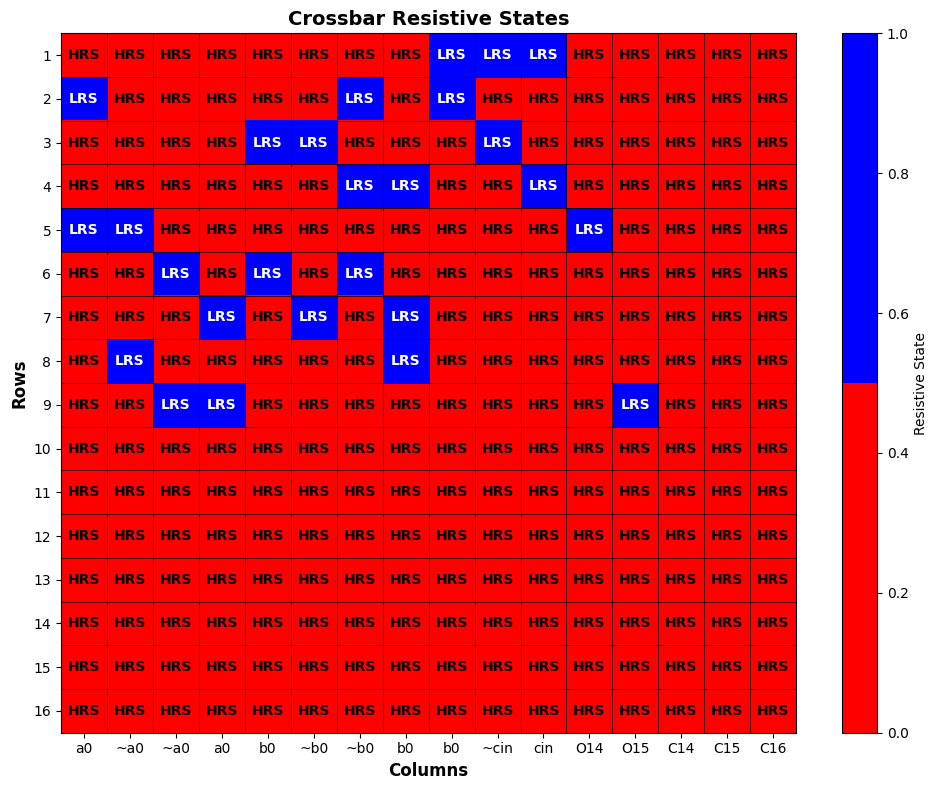

Verifying all ideal paths in the crossbar...
Crossbar verification completed. Total mismatches: 0
path.WorstCaseCrossbarPaths [[(0, 10), (3, 10), (3, 6), (1, 6), (1, 0), (4, 0), (4, 11)], [(0, 10), (3, 10), (3, 6), (5, 6), (5, 2), (8, 2), (8, 12)]]
path.ActiveSelectorLines_indexes {0, 2, 6, 10, 11, 12}
Iteration 1 took 1.182828 seconds
----------------------------------------------------------------------------------------------
BDD has no issues
BDD verification completed.
Start nodes (in-degree = 0): {'ID': '24', 'literal': '1', 'ExpressionRoot': None, 'BipartitePart': 'U1'}
max_depth: 7
last_split: EdgeNode_5
Suitable Crossbar size: 32
self.BDDlongPaths [['24', 'EdgeNode_26', '36', 'EdgeNode_14', '48', 'EdgeNode_5', '44', 'EdgeNode_2', '52', 'EdgeNode_31'], ['24', 'EdgeNode_26', '36', 'EdgeNode_14', '48', 'EdgeNode_7', '43', 'EdgeNode_4', '52', 'EdgeNode_31'], ['24', 'EdgeNode_27', '34', 'EdgeNode_16', '42', 'EdgeNode_9', '44', 'EdgeNode_2', '52', 'EdgeNode_31'], ['24', 'EdgeNode_27

In [17]:
filename_lst = {str(i)+"-bitAdder":"bdds/"+str(i)+"-bitAdder.sbdd" for i in range(1, 18+1)}
with open("Data/truth_tables_data.pkl", "rb") as f:
    truth_tables_data = pickle.load(f)

Functional_Logic_Of_Path_Crossbar_Programings = {}
for adderbit in range(1, 18+1):
    start_time = time.time()
    adder_index = adderbit-1
    filename = filename_lst[str(adderbit)+'-bitAdder']

    if(adderbit<10):
        outputs, df = truth_tables_data[str(adderbit)+'-bitAdder']["outputs"], truth_tables_data[str(adderbit)+'-bitAdder']["TruthTable_df"]
    else:
        outputs, df = None, None
        
    path = PATH(CrossbarGridSize = 64)
    # path.TruthTable_to_BooleanExpression(df, outputs=outputs)
    # path.BooleanExpresions_to_BDD()
    # print("----------------------------------------------------------------------------------------------")
    # expressions = {'F0' : '(a & b) | (a & cin) | (b & cin)',
    # 'F1' : '(a & b & cin) | (a & ~b & ~cin) | (b & ~a & ~cin) | (cin & ~a & ~b)'}
    # variables = ['a', 'b', 'cin']
    # path.SetBooleanExpressionsAndVaribles(variables = variables, expressions = expressions, outputs = list(expressions.keys()))
    # print("----------------------------------------------------------------------------------------------")
    
    path.SetBooleanExpressionsAndVaribles(variables = None, expressions = None, outputs = outputs, OriginalTruthTable=df)
    path.parse_file_to_NetworkXGraph(filename)
    path.BDD_to_NetworkXGraph()
    if(adderbit<4):
        path.Verify_BDD_to_NetworkXGraph(withExpression=False, withOriginalTruthTable=True)
    # path.VisuvaliseNetworkXGraph()
    # print("----------------------------------------------------------------------------------------------")
    path.GraphPreprocessing()
    # path.VisuvaliseNetworkXGraph()
    # print("----------------------------------------------------------------------------------------------")
    path.GraphTransformation()
    # path.VisuvaliseNetworkXGraph(bipartite=True)
    # print("----------------------------------------------------------------------------------------------")
    path.GraphCompression()
    # path.VisuvaliseNetworkXGraph(bipartite=True)
    # print("----------------------------------------------------------------------------------------------")

    path.LongestpathInTreeAndCrossbar()
    path.find_last_possible_split()
    
    path.CrossbarRelalization()
    if(adderbit==1):
        path.VisuvaliseCrossbar()
    if(adderbit<=4):
        path.Verify_All_Ideal_Paths_In_Crossbar()

    # print('path.AllIdealPathOfCurrent',path.AllIdealPathOfCurrent.keys())
    
    # print(path.OutputLine_Map)
    # print(path.SBDD_dimentions)
    # print("total_Paths2========>",len(path.AllIdealPathOfCurrent.keys()))
    Functional_Logic_Of_Path_Crossbar_Programings[str(adderbit)+'-bitAdder'] = {'Crossbar':path.CrossbarResistiveStates, 'Bitlines':path.Bitlines, 'TruthTable':path.OriginalTruthTable, 'OutputLine_Map':path.OutputLine_Map, 'AdderBit':str(adderbit)+'-bitAdder', 'SBDD (V x E)':path.SBDD_dimentions, 'AllIdealPathOfCurrent': path.AllIdealPathOfCurrent, 'LongestPathOfCurrent':path.LongestPathOfCurrent, 'CountOfLongestPath':path.CountOfLongestPath, 'CrossbarLongPaths':path.CrossbarLongPaths}
    print('path.WorstCaseCrossbarPaths',path.WorstCaseCrossbarPaths)
    print('path.ActiveSelectorLines_indexes',path.ActiveSelectorLines_indexes)
    
    print(f"Iteration {adderbit} took {time.time() - start_time:.6f} seconds")

    # print('path.CrossbarLongPaths',path.CrossbarLongPaths)
    print("----------------------------------------------------------------------------------------------")
    if(adderbit==5):
        break

# Save (pickle) to a file
with open("Data/Functional_Logic_Of_Path_Crossbar_Programings.pkl", "wb") as f:
    pickle.dump(Functional_Logic_Of_Path_Crossbar_Programings, f)

print("Data saved to multi_data.pkl")

In [18]:
# def generate_adder_truth_table(num_bits: int):
#     """
#     Generate a truth table for an N-bit adder with carry-in and carry-out.
    
#     Inputs: a0..a{num_bits-1}, b0..b{num_bits-1}, cin
#     Outputs: sum0..sum{num_bits-1}, cout
    
#     Returns:
#         df (pd.DataFrame): the truth table
#         outputs (List[str]): list of output column names
#     """
#     # Prepare column names for inputs
#     a_cols = [f"a{i}" for i in range(num_bits)]
#     b_cols = [f"b{i}" for i in range(num_bits)]
#     input_cols = a_cols + b_cols + ["cin"]
    
#     # Prepare column names for outputs
#     sum_cols = [f"sum{i}" for i in range(num_bits)]
#     outputs = sum_cols + ["cout"]
    
#     # List to store all rows of the truth table
#     rows = []
    
#     # Iterate over all possible values of A, B, and carry-in
#     # A and B each go from 0 to (2^num_bits - 1), cin from 0 to 1
#     for a_val in range(2**num_bits):
#         for b_val in range(2**num_bits):
#             for cin_val in [0, 1]:
#                 # Calculate the actual sum
#                 total = a_val + b_val + cin_val
                
#                 # The sum in binary will have up to num_bits+1 bits
#                 # because of a possible carry-out
#                 sum_bin = f"{total:0{num_bits+1}b}"
                
#                 # Lower num_bits bits are the sum bits
#                 # The leftmost bit is the final carry out if it exists
#                 # For an N-bit sum + carry out, sum_bin has (N+1) bits
#                 sum_part = sum_bin[-num_bits:]      # last N bits
#                 carry_out = sum_bin[0:-(num_bits)]  # leading bits (could be more than 1 if total is large, but typically 1 or 0)
                
#                 # If sum_bin has more than N+1 bits, carry_out could be more than 1 digit in theory.
#                 # Usually for an N-bit adder, we only look at the final 1 bit of carry out.
#                 # So we can treat the carry_out as the leftmost bit (or 0 if length < 2).
#                 cout_val = int(carry_out, 2) if carry_out else 0
                
#                 # Decompose a_val, b_val into bits
#                 # We'll get each bit from least significant to most significant
#                 a_bits = [(a_val >> i) & 1 for i in range(num_bits)]
#                 b_bits = [(b_val >> i) & 1 for i in range(num_bits)]
                
#                 # Build the row dictionary
#                 row = {}
#                 # Fill in a_i columns
#                 for i in range(num_bits):
#                     row[f"a{i}"] = a_bits[i]
#                 # Fill in b_i columns
#                 for i in range(num_bits):
#                     row[f"b{i}"] = b_bits[i]
                
#                 # Carry in
#                 row["cin"] = cin_val
                
#                 # sum bits
#                 for i in range(num_bits):
#                     row[f"sum{i}"] = int(sum_part[num_bits - 1 - i])  # reverse indexing
#                 row["cout"] = cout_val
                
#                 rows.append(row)
    
#     df = pd.DataFrame(rows, columns=input_cols + outputs)
#     return df, outputs

# # Example usage for different bit widths:
# df, outputs = generate_adder_truth_table(1)

# print("1-bit Adder Truth Table:")
# # print(df)
# print("Outputs:", outputs)
# df

In [19]:
# tt_no = 10
# truth_tables_data = {}

# for i in range(1, tt_no + 1):
#     start_time = time.time()  # Record start
    
#     df, outputs = generate_adder_truth_table(i)
#     truth_tables_data[str(i)+'-bitAdder'] = {"outputs":outputs, "TruthTable_df":df}
    
#     print(f"Iteration {i} took {time.time() - start_time:.6f} seconds")

# # Save (pickle) to a file
# with open("Data/truth_tables_data.pkl", "wb") as f:
#     pickle.dump(truth_tables_data, f)

# print("written in truth_tables_data.pkl")

In [20]:
length_frequency = {}

for adderBit in Functional_Logic_Of_Path_Crossbar_Programings:
    for entry in Functional_Logic_Of_Path_Crossbar_Programings[adderBit]['AllIdealPathOfCurrent'].values():
        for key in entry:
            length = entry[key]['lengthOfDevices']
            if length in length_frequency:
                length_frequency[length] += 1
            else:
                length_frequency[length] = 1
    
    # Print frequency counts
    print("Frequency of LengthOfDevices values:")
    for length, count in length_frequency.items():
        print(f"Length {length}: {count} times")
    print()

Frequency of LengthOfDevices values:
Length 7: 6 times
Length 5: 2 times

Frequency of LengthOfDevices values:
Length 7: 22 times
Length 5: 10 times
Length 11: 12 times
Length 9: 12 times

Frequency of LengthOfDevices values:
Length 7: 86 times
Length 5: 42 times
Length 11: 44 times
Length 9: 92 times
Length 15: 24 times
Length 13: 24 times

Frequency of LengthOfDevices values:
Length 7: 342 times
Length 5: 170 times
Length 11: 172 times
Length 9: 540 times
Length 15: 88 times
Length 13: 184 times
Length 19: 48 times
Length 17: 48 times

Frequency of LengthOfDevices values:
Length 7: 342 times
Length 5: 170 times
Length 11: 172 times
Length 9: 540 times
Length 15: 88 times
Length 13: 184 times
Length 19: 48 times
Length 17: 48 times



In [21]:
import math

def four_sig_truncate(num):
    """
    Truncates a positive float 'num' to exactly 4 significant digits.
    For example:
      1.357371568 -> '1.357'
      4.69340734797519e-6 -> '4.693e-06'
    """
    if num == 0:
        return "0"  # edge case
    
    # Get sign and make num positive if it isn't
    sign = "-" if num < 0 else ""
    num = abs(num)
    
    # Find base-10 exponent (e.g., 1.357... => exp=0, 4.693e-6 => exp ~ -5, etc.)
    exp = math.floor(math.log10(num))
    
    # Scale to get leading digit(s) (mantissa >= 1 and < 10)
    # e.g., for 1.357..., mantissa ~ 1.357
    # for 4.693e-6, mantissa ~ 4.693
    mantissa = num / (10**exp)
    
    # We want 4 significant digits total.
    # Multiply by 10^(4 - 1) = 10^3 = 1000. Then truncate.
    # This will keep exactly 4 digits before the decimal, effectively.
    mantissa_scaled = int(mantissa * 1000)  # truncation, no rounding
    mantissa_trunc = mantissa_scaled / 1000.0
    
    # If mantissa_trunc became >= 10 (very edge case), adjust
    if mantissa_trunc >= 10:
        mantissa_trunc /= 10
        exp += 1
    
    # If exponent is in [–3, 3], we might prefer normal notation (like '1.234') 
    # but to stick to a consistent style, let's always use e-notation if exp != 0:
    if exp == 0:
        # Just attach the sign
        return f"{sign}{mantissa_trunc}"
    else:
        return f"{sign}{mantissa_trunc}e{exp:+d}"

# Example usage
val1 = 1.3573715686798096
val2 = 4.69340734797519e-6

print(four_sig_truncate(val1))  # 1.357
print(four_sig_truncate(val2))  # 4.693e-06

def extend_path_by_two(orig_path):
    
    new_path = []
    new_path.extend(orig_path[:-2])

    subpath = []
    final_node = orig_path[-1]
    
    prev1, prev2 = new_path[-1], new_path[-2]

    used_Rows = {row for row,_ in orig_path}
    used_Cols = {col for _,col in orig_path}

    maxCellNum = 0
    for row, col in orig_path:
        maxCellNum = max(maxCellNum, row, col)
    
    notused_Col = None
    notused_Row = None
    for cell in range(maxCellNum+1):
        if(cell not in used_Rows and notused_Row is None):
            notused_Row = cell
        elif(cell not in used_Cols and notused_Col is None):
            notused_Col = cell

    # print(notused_Row, notused_Col)
    
    if(prev1[0]==prev2[0]):
            subpath.append((notused_Row, prev1[1]))
            subpath.append((notused_Row, notused_Col))
            subpath.append((final_node[0], notused_Col))
    elif(prev1[1]==prev2[1]):
        print("dont know")
        return
    
    new_path.extend(subpath)
    new_path.append(final_node)
    
    return new_path

# ---------------------------
# Example usage:
original_path = [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (8, 3), (8, 12)]
# [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (7, 3), (7, 4), (8, 4), (8, 12)]
extended = extend_path_by_two(original_path)
print("Original:", original_path)
print("Extended:", extended)

1.357
4.693e-6
Original: [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (8, 3), (8, 12)]
Extended: [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (1, 3), (1, 0), (8, 0), (8, 12)]


In [32]:
class AnalogTestingOfPathCrossbar:
    def __init__(self, Crossbar, Bitlines, TruthTable, OutputLine_Map, AllIdealPathOfCurrent=None, LongestPathOfCurrent=None, CrossbarLongPaths=None):
        self.Crossbar = Crossbar
        self.Bitlines = Bitlines
        self.TruthTable = TruthTable
        self.OutputLabelsToBitlineIndexMap = {OutputLine_Map[key]:Bitlines.index(key) for key in OutputLine_Map}  #imp
        self.OutputBitlineIndexMapToLabels = {Bitlines.index(key):OutputLine_Map[key] for key in OutputLine_Map}
        self.AllIdealPathOfCurrent = AllIdealPathOfCurrent
        self.AdderNumDevicesToCurrents_Map = {}
        self.LongestPathOfCurrent = LongestPathOfCurrent
        self.CrossbarLongPaths = CrossbarLongPaths
        
        self.tempMatrix = None

    def initialiseCrossbar(self, input_assignment={}):
        CrossbarCopy = [row.copy() for row in self.Crossbar]
        # self.Bitline

        selectorLinesDeactive = []
        print('self.Bitlines',self.Bitlines)
        for col_j, bitline in enumerate(self.Bitlines):
            literal = bitline
            negation = True if literal[0]=='~' else False
            if(negation):
                literal=literal[1:]
            flag=True
            if('O' in literal):
                flag=False
            elif(literal in input_assignment and input_assignment[literal]==0):
                if(negation):
                    flag=False
            elif(literal in input_assignment and input_assignment[literal]==1):
                if(not negation):
                    flag=False
            if(flag):
                for row_i in range(len(CrossbarCopy)):
                    CrossbarCopy[row_i][col_j] = 2
                selectorLinesDeactive.append(col_j)
        # print('selectorLinesDeactive',selectorLinesDeactive)
        # print('selectorActivelines',[i for i in range(0,len(self.Crossbar)) if i not in selectorLinesDeactive])
            

        return CrossbarCopy

    def SufficientCase_initialiseCrossbar(self, output, outputline=None, longestPath=None, shortPaths=None):
        if(output==0):
            CrossbarCopy = [row.copy() for row in self.Crossbar]
            for i in range(len(CrossbarCopy)):
                CrossbarCopy[i][outputline] = 0
        if(output==1):
            CrossbarCopy = [[0 for _ in row] for row in self.Crossbar]
            usedColumnsForSelectorLines = set()
            if(longestPath):
                for cell in longestPath:
                    CrossbarCopy[cell[0]][cell[1]]=1
                    usedColumnsForSelectorLines.add(cell[1])
            if(shortPaths):
                for shortPathCell in shortPaths:
                    print(shortPathCell)
                    CrossbarCopy[shortPathCell[0]][shortPathCell[1]]=1
                    usedColumnsForSelectorLines.add(shortPathCell[1])
            
            for col_j in range(len(self.Crossbar[0])):
                for row_i in range(len(CrossbarCopy)):
                    if(col_j not in usedColumnsForSelectorLines):
                        CrossbarCopy[row_i][col_j] = 2
            
        return CrossbarCopy

    # def NodalAnalysis(self, Initialized_Crossbar, variable_HRS, output_bitlines):
    #     """
    #     Performs a nodal (KCL) analysis on the given Initialized_Crossbar
    #     using variable_HRS as the high-resistance state (HRS).
        
    #     Returns:
    #         Output_current_map (dict): Maps each output line label to its computed current.
    #     """
    #     # print('variable_HRS',variable_HRS)
        
    #     # Define resistor parameters
    #     R_Off       = max(2e9,variable_HRS)        # Very large (transistor off)
    #     R_HRS       = variable_HRS # High-resistance state of the memory cell
    #     R_LRS       = 5000        # Low-resistance state
    #     R_Line_Out  = 2e2         # e.g., 200 ohms from each column node to GND
    #     R_Not       = max(2e9,variable_HRS)         # Large resistance for non-output columns
    
    #     # We'll use the user-provided crossbar as our base matrix of resistances
    #     Resitance_matrix = [row.copy() for row in Initialized_Crossbar]
    #     crossbar_size = len(Initialized_Crossbar)

    #     # Replace 0 with R_HRS and 1 with R_LRS
    #     for i in range(crossbar_size):
    #         for j in range(crossbar_size):
    #             if Resitance_matrix[i][j] == 0:
    #                 Resitance_matrix[i][j] = R_HRS
    #             elif Resitance_matrix[i][j] == 1:
    #                 Resitance_matrix[i][j] = R_LRS
    #             elif Resitance_matrix[i][j] == 2:
    #                 Resitance_matrix[i][j] = R_Off
                    
    #     # print('Resitance_matrix',Resitance_matrix[0])
        
    #     voltage_row_variables = " ".join(["Vr"+str(i) for i in range(1,crossbar_size+1)])
    #     voltage_col_variables = " ".join(["Vc"+str(i) for i in range(1,crossbar_size+1)])
        
    #     # ----------------------------------------------------------------
    #     # 1) Construct the system of equations for 8 row voltages + 8 column voltages
    #     # We'll define these symbolic variables:
    #     Vr = sympy.symbols(voltage_row_variables, real=True)
    #     Vc = sympy.symbols(voltage_col_variables, real=True)
    #     x_vars = list(Vr) + list(Vc)
    
    #     # Voltage source for the first row (example: 0.2V)
    #     Vsrc = 0.2
    
    #     equations = []
    #     # Build row equations
    #     for i in range(crossbar_size):
    #         if i == 0:
    #             # First word line connected to the voltage source
    #             eq_i = sympy.Eq(Vr[i], Vsrc)
    #         else:
    #             row_sum = 0
    #             for j in range(crossbar_size):
    #                 # KCL: sum of currents from row node i to each column node j
    #                 row_sum += (Vr[i] - Vc[j]) / Resitance_matrix[i][j]
    #             eq_i = sympy.Eq(row_sum, 0)
    #         equations.append(eq_i)

    #     # Build column equations
    #     for j in range(crossbar_size):
    #         # If this column is an output line, it goes to ground through R_Line_Out;
    #         if j in output_bitlines:
    #             col_to_ground = Vc[j] / R_Line_Out
    #         else:
    #             col_to_ground = Vc[j] / R_Not
            
    #         col_sum = 0
    #         for i in range(crossbar_size):
    #             col_sum += (Vc[j] - Vr[i]) / Resitance_matrix[i][j]
            
    #         eq_j = sympy.Eq(col_to_ground + col_sum, 0)
    #         equations.append(eq_j)
    
    #     # ----------------------------------------------------------------
    #     # 2) Solve the system A*x = b
    #     A, b = sympy.linear_eq_to_matrix(equations, x_vars)
    #     # solution = A.LUsolve(b)

    #     # Convert sympy Matrix A to a NumPy 2D array:
    #     A_np = np.array(A.tolist(), dtype=float)
        
    #     # Convert sympy Matrix b to a 1D or 2D NumPy array:
    #     b_np = np.array(b.tolist(), dtype=float)

    #     # If b_np is shape (n, 1), flatten to (n,):
    #     if b_np.ndim == 2 and b_np.shape[1] == 1:
    #         b_np = b_np.ravel()

    #     #numpy matrix solver
    #     # solution = np.linalg.solve(A_np, b_np)

    #     self.tempMatrix = [A_np, b_np]

    #     #Scipy sparce matrix solver
    #     A_sparse = sp.csr_matrix(A_np)
    #     solution = spla.spsolve(A_sparse, b_np)
    
    #     # Convert solution to a dictionary of evaluated voltages (in millivolts, for example)
    #     Voltages = {}
    #     for var, val in zip(x_vars, solution):
    #         Voltages[str(var)] = val * 1000  # mV if you want, else remove *1000
    #         # Voltages[str(var)] = val.evalf() * 1000  # mV if you want, else remove *1000
    
    #     # ----------------------------------------------------------------
    #     # 3) Compute currents through each resistor
    #     # currentInDevices[i][j] = (Vr_i - Vc_j) / R(i,j)
    #     currentInDevices = [[0.0 for _ in range(crossbar_size)] for _ in range(crossbar_size)]
    #     for i in range(crossbar_size):
    #         for j in range(crossbar_size):
    #             # Convert back from millivolts to volts if you multiplied by 1000
    #             Vr_i = Voltages[f"Vr{i+1}"] / 1000
    #             Vc_j = Voltages[f"Vc{j+1}"] / 1000
    #             currentInDevices[i][j] = (Vr_i - Vc_j) / Resitance_matrix[i][j]
    
    #     # ----------------------------------------------------------------
    #     # 4) Compute the output current for each labeled output and non-labled output
    #     Output_current_map = {}
    #     for col_idx in range(1,crossbar_size+1):
    #         Vc_col = Voltages[f"Vc{col_idx}"] / 1000
    #         if(col_idx-1 in output_bitlines):
    #             Output_current_map[col_idx-1]=Vc_col / R_Line_Out

    #     # print('output_bitlines',output_bitlines)
    #     # print('Output_current_map',Output_current_map)
    #     # print('end of nodal analysis')
    #     return Output_current_map

    def NodalAnalysis(self, Initialized_Crossbar, variable_HRS, output_bitlines):
        """
        Performs a nodal (KCL) analysis on the given Initialized_Crossbar
        using variable_HRS as the high-resistance state (HRS).
    
        Returns:
            Output_current_map (dict): Maps each output line label to its computed current.
        """
        # Define resistor parameters
        R_Off = 2e9  # Very large (transistor off)
        R_HRS = variable_HRS  # High-resistance state of the memory cell
        R_LRS = 2000  # Low-resistance state
        R_Line_Out = 200  # 200 ohms from each column node to GND
        R_Not = 2e9  # Large resistance for non-output columns
        R_source   = 100  # Series resistor from 0.2 V source to row 0
        
        # Voltage source for the first row (0.2V)
        Vsrc = 0.2  
    
        # -----------------------------
        # 2) Prepare the crossbar data
        # -----------------------------
        crossbar_size = len(Initialized_Crossbar)
        Initialized_Crossbar = np.array(Initialized_Crossbar)
    
        # Build the final resistance matrix:
        #    0 => R_HRS
        #    1 => R_LRS
        #    2 => R_Off
        Resistance_matrix = np.where(Initialized_Crossbar == 0, R_HRS, 
                                    np.where(Initialized_Crossbar == 1, R_LRS, 
                                             np.where(Initialized_Crossbar == 2, R_Off, Initialized_Crossbar)))
    
        # -----------------------------
        # 3) Construct the KCL system
        #    We have #rows + #columns unknowns:
        #       Vr0, Vr1, ..., Vr(N-1), Vc0, Vc1, ..., Vc(N-1)
        # -----------------------------
        num_vars = 2 * crossbar_size  
        A = np.zeros((num_vars, num_vars))  # Coefficient matrix
        b = np.zeros(num_vars)  # Constant vector
    
        # Define row equations (KCL)
        # for i in range(crossbar_size):
        #     if i == 0:
        #         # First row is directly connected to the voltage source
        #         A[i, i] = 1
        #         b[i] = Vsrc
        #     else:
        #         for j in range(crossbar_size):
        #             Rij = Resistance_matrix[i][j]
        #             A[i, i] += 1 / Rij  # Self term
        #             A[i, crossbar_size + j] -= 1 / Rij  # Interaction with column

        # -----------------------------
        # 3a) Row equations (KCL at each row node)
        # -----------------------------
        for i in range(crossbar_size):
            if i == 0:
                #
                # For row 0, we have an incoming/outgoing current through R_source to the 0.2V supply.
                # The KCL for row 0 is:
                #   Σ_j (Vr0 - Vc_j)/R(i,j) + (Vr0 - 0.2)/R_source = 0
                #
                for j in range(crossbar_size):
                    Rij = Resistance_matrix[i, j]
                    A[i, i]                += 1.0 / Rij    # +1/Rij for Vr[i]
                    A[i, crossbar_size + j] -= 1.0 / Rij    # -1/Rij for Vc[j]

                # Now add the series resistor with the source (0.2 V):
                A[i, i] += 1.0 / R_source  # Coefficient for Vr0
                
                # Move the known source voltage part to the RHS
                b[i] = (Vsrc / R_source)
    
            else:
                # For row i (i > 0), normal crossbar KCL with no direct voltage source:
                #   Σ_j (Vri - Vcj)/R(i,j) = 0
                for j in range(crossbar_size):
                    Rij = Resistance_matrix[i, j]
                    A[i, i]                += 1.0 / Rij    # Coefficient for Vr_i
                    A[i, crossbar_size + j] -= 1.0 / Rij   # Coefficient for Vc_j
                # b[i] remains 0
        
    
        # -----------------------------
        # 3b) Column equations (KCL at each column node)
        #       If the column is in output_bitlines => goes to GND through R_Line_Out
        #       Otherwise => goes to GND through R_Not
        # -----------------------------
        # print('output_bitlines',output_bitlines)
        for j in range(crossbar_size):
            if j in output_bitlines:
                R_ground = R_Line_Out  # If it's an output bitline, connects to ground through R_Line_Out
            else:
                R_ground = R_Not  # If not an output bitline, connect to ground through R_Not

            # The KCL for column j is:
            #    Vc_j / R_ground + Σ_i (Vc_j - Vr_i)/R(i,j) = 0
            #
            # Expand:
            #    (Vc_j / R_ground) + Σ_i (Vc_j / R(i,j) - Vr_i / R(i,j)) = 0
            # => (1/R_ground + Σ_i (1/R(i,j))) * Vc_j  - Σ_i(1/R(i,j)) * Vr_i = 0
            
            A[crossbar_size + j, crossbar_size + j] = 1 / R_ground  # Self term
            for i in range(crossbar_size):
                Rij = Resistance_matrix[i][j]
                A[crossbar_size + j, crossbar_size + j] += 1 / Rij  # Self term
                A[crossbar_size + j, i] -= 1 / Rij  # Interaction with row
    
        # -----------------------------
        # 4) Solve the system A x = b
        #    where x = [Vr_0, ..., Vr_(N-1), Vc_0, ..., Vc_(N-1)]
        # -----------------------------
        solution = np.linalg.solve(A, b)
    
        # Extract row voltages Vr and column voltages Vc
        Vr = solution[:crossbar_size]*1000  # Row voltages
        Vc = solution[crossbar_size:]*1000  # Column voltages
    
        # Compute currents through each resistor
        currentInDevices = (Vr[:, None] - Vc[None, :]) / Resistance_matrix
    
        # -----------------------------
        # 5) Compute output currents
        #    The current from each output column j is simply
        #    I_out(j) = Vc_j / R_Line_Out (if j is an output bitline)
        # -----------------------------
        Output_current_map = {j: Vc[j] / R_Line_Out for j in output_bitlines}

        # print('Output_current_map',Output_current_map)

        print('Vr',Vr)
        print('Vc',Vc)
        # print('---------')
    
        return Output_current_map

    def SufficientCase_NodalAnalysis(self, Initialized_Crossbar, variable_HRS, output_bitlines, output):
        """
        Performs a nodal (KCL) analysis on the given Initialized_Crossbar
        using variable_HRS as the high-resistance state (HRS).
    
        Returns:
            Output_current_map (dict): Maps each output line label to its computed current.
        """
        # Define resistor parameters
        R_Off = 2e9  # Very large (transistor off)
        R_HRS = variable_HRS  # High-resistance state of the memory cell
        R_LRS = 2000  # Low-resistance state
        R_Line_Out = 200  # 200 ohms from each column node to GND
        R_Not = 2e9  # Large resistance for non-output columns
        R_source   = 100  # Series resistor from 0.2 V source to row 0
        
        # Voltage source for the first row (0.2V)
        Vsrc = 0.2  
    
        # -----------------------------
        # 2) Prepare the crossbar data
        # -----------------------------
        crossbar_size = len(Initialized_Crossbar)
        Initialized_Crossbar = np.array(Initialized_Crossbar)
    
        # Build the final resistance matrix:
        #    0 => R_HRS
        #    1 => R_LRS
        #    2 => R_Off
        Resistance_matrix = np.where(Initialized_Crossbar == 0, R_HRS, 
                                    np.where(Initialized_Crossbar == 1, R_LRS, 
                                             np.where(Initialized_Crossbar == 2, R_Off, Initialized_Crossbar)))
    
        # -----------------------------
        # 3) Construct the KCL system
        #    We have #rows + #columns unknowns:
        #       Vr0, Vr1, ..., Vr(N-1), Vc0, Vc1, ..., Vc(N-1)
        # -----------------------------
        num_vars = 2 * crossbar_size  
        A = np.zeros((num_vars, num_vars))  # Coefficient matrix
        b = np.zeros(num_vars)  # Constant vector
    
        # Define row equations (KCL)
        # for i in range(crossbar_size):
        #     if i == 0:
        #         # First row is directly connected to the voltage source
        #         A[i, i] = 1
        #         b[i] = Vsrc
        #     else:
        #         for j in range(crossbar_size):
        #             Rij = Resistance_matrix[i][j]
        #             A[i, i] += 1 / Rij  # Self term
        #             A[i, crossbar_size + j] -= 1 / Rij  # Interaction with column

        # -----------------------------
        # 3a) Row equations (KCL at each row node)
        # -----------------------------
        for i in range(crossbar_size):
            if i == 0:
                #
                # For row 0, we have an incoming/outgoing current through R_source to the 0.2V supply.
                # The KCL for row 0 is:
                #   Σ_j (Vr0 - Vc_j)/R(i,j) + (Vr0 - 0.2)/R_source = 0
                #
                for j in range(crossbar_size):
                    Rij = Resistance_matrix[i, j]
                    A[i, i]                += 1.0 / Rij    # +1/Rij for Vr[i]
                    A[i, crossbar_size + j] -= 1.0 / Rij    # -1/Rij for Vc[j]

                # Now add the series resistor with the source (0.2 V):
                A[i, i] += 1.0 / R_source  # Coefficient for Vr0
                
                # Move the known source voltage part to the RHS
                b[i] = (Vsrc / R_source)
    
            else:
                # For row i (i > 0), normal crossbar KCL with no direct voltage source:
                #   Σ_j (Vri - Vcj)/R(i,j) = 0
                for j in range(crossbar_size):
                    Rij = Resistance_matrix[i, j]
                    A[i, i]                += 1.0 / Rij    # Coefficient for Vr_i
                    A[i, crossbar_size + j] -= 1.0 / Rij   # Coefficient for Vc_j
                # b[i] remains 0
        
    
        # -----------------------------
        # 3b) Column equations (KCL at each column node)
        #       If the column is in output_bitlines => goes to GND through R_Line_Out
        #       Otherwise => goes to GND through R_Not
        # -----------------------------
        # print('output_bitlines',output_bitlines)
        for j in range(crossbar_size):
            if j in output_bitlines:
                R_ground = R_Line_Out  # If it's an output bitline, connects to ground through R_Line_Out
            else:
                R_ground = R_Not  # If not an output bitline, connect to ground through R_Not

            # The KCL for column j is:
            #    Vc_j / R_ground + Σ_i (Vc_j - Vr_i)/R(i,j) = 0
            #
            # Expand:
            #    (Vc_j / R_ground) + Σ_i (Vc_j / R(i,j) - Vr_i / R(i,j)) = 0
            # => (1/R_ground + Σ_i (1/R(i,j))) * Vc_j  - Σ_i(1/R(i,j)) * Vr_i = 0
            
            A[crossbar_size + j, crossbar_size + j] = 1 / R_ground  # Self term
            for i in range(crossbar_size):
                Rij = Resistance_matrix[i][j]
                A[crossbar_size + j, crossbar_size + j] += 1 / Rij  # Self term
                A[crossbar_size + j, i] -= 1 / Rij  # Interaction with row

        # -----------------------------
        # 4) Solve the system A x = b
        #    where x = [Vr_0, ..., Vr_(N-1), Vc_0, ..., Vc_(N-1)]
        # -----------------------------
        solution = np.linalg.solve(A, b)
    
        # Extract row voltages Vr and column voltages Vc
        Vr = solution[:crossbar_size]*1000  # Row voltages
        Vc = solution[crossbar_size:]*1000  # Column voltages
    
        # Compute currents through each resistor
        currentInDevices = (Vr[:, None] - Vc[None, :]) / Resistance_matrix
    
        # Compute the output currents
        # Output_current_map = {j: Vc[j] / R_Line_Out for j in output_bitlines}

        mainOutput = output_bitlines[0]

        # print('Vr',Vr)
        # print('Vc',Vc)
    
        return Vc[mainOutput] / R_Line_Out
        
    def Iteration_Of_Each_Row_In_the_TruthTable(self, variable_HRS):

        output_cols = list(self.OutputLabelsToBitlineIndexMap.keys())
        input_columns = [col for col in self.TruthTable.columns if col not in output_cols]  # Variables
        output_columns = [col for col in self.TruthTable.columns if col in output_cols]  # Expressions (functions)

        zerosCurrents, onesCurrents = [], []
        # Iterate over each row in the truth table
        for idx, row in self.TruthTable.iterrows():
            input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary {'a0':0, 'b0':0, 'cin':1}
            expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

            start_time_iteration = time.time()
            
            #setting selector lines -> crossbar matrix
            Initialized_Crossbar = self.initialiseCrossbar(input_assignment)
            
            #running nodal analysis -> current in each bitlines
            currentOutputs = self.NodalAnalysis(Initialized_Crossbar, variable_HRS, output_bitlines=self.OutputLabelsToBitlineIndexMap.values())
            # print('currentOutputs',currentOutputs)

            # newcurrentOutputs = {self.OutputBitlineIndexMapToLabels[key]:four_sig_truncate(currentOutputs[key]) for key in currentOutputs}
            newcurrentOutputs = {self.OutputBitlineIndexMapToLabels[key]:currentOutputs[key] for key in currentOutputs}

            # print('expected_outputs',expected_outputs, "Duration:", four_sig_truncate(time.time()-start_time_iteration),"sec")
            # print('newcurrentOutputs',newcurrentOutputs)

            print('input_assignment', input_assignment)
            
            # check min and max curretns at expected_outputs using this AnalogPathTest.OutputLabelsToBitlineIndexMap
            for label in expected_outputs:
                outputCurrent = newcurrentOutputs[label]
                if(expected_outputs[label]==0):
                    print('000000', label, outputCurrent)
                    zerosCurrents.append(outputCurrent)
                elif(expected_outputs[label]==1):
                    print('111111', label, outputCurrent)
                    onesCurrents.append(outputCurrent)
                    numberofDevices = AllIdealPathOfCurrent[frozenset(input_assignment.items())][label]["lengthOfDevices"]
                    if(numberofDevices not in self.AdderNumDevicesToCurrents_Map):
                        self.AdderNumDevicesToCurrents_Map[numberofDevices] = []
                    self.AdderNumDevicesToCurrents_Map[numberofDevices].append(outputCurrent)
            # print('expected_outputs',idx,expected_outputs)

        guardBand = min(onesCurrents) - max(zerosCurrents)

        print('min(onesCurrents)1',min(onesCurrents))
        print('max(zerosCurrents)1',max(zerosCurrents))
        # print('guardBand1',guardBand)?\
        
        return {"guardBand":guardBand, "zerosCurrents":zerosCurrents, "onesCurrents":onesCurrents}

    def get_expected_output(self, input_assignment):
        """
        Given an input_assignment dict like:
            {'a0': 0, 'b0': 1, 'cin': 0}
        or:
            {'a0': 0, 'a1': 0, 'b0': 0, 'b1': 1, 'cin': 0}
        etc.
        Return a dict of the form:
            {'sum0': ..., 'sum1': ..., ..., 'cout': ...}
        representing the bitwise sum of a and b, plus cin.
        """
        # Gather all bit indices for a and b.
        a_indices = [int(k[1:]) for k in input_assignment if k.startswith('a')]
        b_indices = [int(k[1:]) for k in input_assignment if k.startswith('b')]
    
        # If there are no bits for a or b (unlikely in practice), just return something empty.
        if not a_indices and not b_indices:
            return {'sum0': 0, 'cout': input_assignment.get('cin', 0)}
    
        max_index = max(a_indices + b_indices)  # highest bit position found
    
        # Convert the bits from the dictionary into integer form for 'a' and 'b'.
        a_val = 0
        b_val = 0
        for i in range(max_index + 1):
            a_bit = input_assignment.get(f'a{i}', 0)
            b_bit = input_assignment.get(f'b{i}', 0)
            # Shift bit i into the correct position
            a_val |= (a_bit << i)
            b_val |= (b_bit << i)
    
        # Get cin (carry in), defaulting to 0 if not present
        cin = input_assignment.get('cin', 0)
    
        # Perform the addition
        total = a_val + b_val + cin
    
        # Convert the sum back into individual bits
        result = {}
        for i in range(max_index + 1):
            result[f'sum{i}'] = (total >> i) & 1
    
        # Extract the carry-out (this is the bit above the highest position)
        cout = (total >> (max_index + 1)) & 1
        result['cout'] = cout
    
        return result

    def Iteration_Of_sufficient_Rows_In_the_TruthTable(self, variable_HRS):
        output_cols = list(self.OutputLabelsToBitlineIndexMap.values())

        zerosCurrents, onesCurrents = [], []

        longestPath_lst = [self.LongestPathOfCurrent]

        # print("max I in zero")
        #worst case maximum current in zero
        # print('output_cols',output_cols)
        for i, output_col in enumerate(output_cols):
            Initialized_Crossbar = self.SufficientCase_initialiseCrossbar(outputline=output_col, output=0)
            
            maxZerocurrent = self.SufficientCase_NodalAnalysis(Initialized_Crossbar, variable_HRS, [output_col], output=0)
            zerosCurrents.append(maxZerocurrent)

        # print("min I in one")#niti
        #worst case minimum current in one
        print('self.CrossbarLongPaths',self.CrossbarLongPaths)
        
        for i, CrossbarLongPathsKey in enumerate(self.CrossbarLongPaths):
            input_assignment = {key: value for (key, value) in CrossbarLongPathsKey}
            
            #setting selector lines -> crossbar matrix
            Initialized_Crossbar = self.initialiseCrossbar(input_assignment)

            #running nodal analysis -> current in each bitlines
            currentOutputs = self.NodalAnalysis(Initialized_Crossbar, variable_HRS, output_bitlines=self.OutputLabelsToBitlineIndexMap.values())

            newcurrentOutputs = {self.OutputBitlineIndexMapToLabels[key]:currentOutputs[key] for key in currentOutputs}
            # print('newcurrentOutputs',newcurrentOutputs)
            
            expected_outputs = self.get_expected_output(input_assignment)
            print('input_assignment',input_assignment)
            for label in expected_outputs:
                outputCurrent = newcurrentOutputs[label]
                if(expected_outputs[label]==0):
                    print('000000',outputCurrent)
                    zerosCurrents.append(outputCurrent)
                if(expected_outputs[label]==1):
                    print('111111',outputCurrent)
                    onesCurrents.append(outputCurrent)
            

        #find scenarios(cases) that have minimal current in 1's and max current in 0's
        #Test only for those cases until 11-bit adder
        
        # ActivateALL the slectorlines
        #Only have 2 outputs one being 1-device in current path and one being longest path
        guardBand = min(onesCurrents) - max(zerosCurrents)

        print('min(onesCurrents)2',min(onesCurrents))
        print('max(zerosCurrents)2',max(zerosCurrents))
        # print('guardBand2',guardBand)
        
        return {"guardBand":guardBand, "zerosCurrents":zerosCurrents, "onesCurrents":onesCurrents}
        

    def Finding_optimal_HRS_using_binarysearch(self, high_variable_HRS=2e9, iterations=2, optimisation=False):
        """
        Perform a binary search to find an optimal high-resistance value (HRS)
        that yields a positive guardValue returned by 'Iteration_Of_Each_Row_In_the_TruthTable'.
        
        Params:
            high_variable_HRS (float): Upper bound for HRS (defaults to 2e9).
            iterations (int): Number of binary search iterations.
    
        Returns:
            float: The last HRS value that produced a positive guardValue, if any.
        """
        lower_bound = 0.0
        upper_bound = high_variable_HRS
    
        guard_values = []
        resistance_values = []
        zerosCurrents_lst = []
        onesCurrents_lst = []
    
        for i in range(iterations):
            # Midpoint of the current lower and upper bounds
            resistance_value = (lower_bound + upper_bound) / 2

            print('resistance_value',resistance_value,i)

            start_time_all_iterations = time.time()

            if(optimisation):
                guardbandMap = self.Iteration_Of_sufficient_Rows_In_the_TruthTable(resistance_value)
            else:
                guardbandMap = self.Iteration_Of_Each_Row_In_the_TruthTable(resistance_value)

            guardband, zerosCurrents, onesCurrents = guardbandMap['guardBand'], guardbandMap['zerosCurrents'], guardbandMap['onesCurrents']
            print('guardBand',guardband, 'Total Duration =',four_sig_truncate(time.time()-start_time_all_iterations),"sec")
            # Decide which way to move in the binary search
            if guardband > 0:
                # If guardband is positive, it means we can try smaller high-resistance
                upper_bound = resistance_value
                guard_values.append(guardband)
                resistance_values.append(resistance_value)
                zerosCurrents_lst.append(zerosCurrents)
                onesCurrents_lst.append(onesCurrents)
            else:
                # Otherwise, we need to go higher
                lower_bound = resistance_value

        return {"guardbands":guard_values, "resistance_values":resistance_values, "zerosCurrents_lst":zerosCurrents_lst, "onesCurrents_lst":onesCurrents_lst, "minOne":min(onesCurrents), "maxZero":max(zerosCurrents)}

In [33]:
with open("Data/Functional_Logic_Of_Path_Crossbar_Programings.pkl", "rb") as f:
    Functional_Logic_Of_Path_Crossbar_Programings = pickle.load(f)
Functional_Logic_Of_Path_Crossbar_Programings_keys = list(Functional_Logic_Of_Path_Crossbar_Programings.keys())

Adder_guardbandsVsReistancesDetailsMaps = {}

In [34]:
start = 0
iterations = 1

real_min_One, real_max_Zero = [], []
for i in range(start, len(Functional_Logic_Of_Path_Crossbar_Programings_keys)):
    adderName = Functional_Logic_Of_Path_Crossbar_Programings_keys[i]
    Functional_Logic_Of_Path_Crossbar_Programing_map = Functional_Logic_Of_Path_Crossbar_Programings[adderName]
    
    start_time = time.time()
    start_dt = datetime.datetime.fromtimestamp(start_time)

    n = len(Functional_Logic_Of_Path_Crossbar_Programing_map['Crossbar'])
    print(f"processing {adderName}. Crossbar dim.:{n}x{n} Started on {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
    Crossbar = Functional_Logic_Of_Path_Crossbar_Programing_map['Crossbar']
    Bitlines = Functional_Logic_Of_Path_Crossbar_Programing_map['Bitlines']
    TruthTable = Functional_Logic_Of_Path_Crossbar_Programing_map['TruthTable']
    OutputLine_Map = Functional_Logic_Of_Path_Crossbar_Programing_map['OutputLine_Map']
    SBDD_dimentions = Functional_Logic_Of_Path_Crossbar_Programing_map['SBDD (V x E)']
    AllIdealPathOfCurrent = Functional_Logic_Of_Path_Crossbar_Programing_map['AllIdealPathOfCurrent']
    LongestPathOfCurrent = Functional_Logic_Of_Path_Crossbar_Programing_map['LongestPathOfCurrent']
    CrossbarLongPaths = Functional_Logic_Of_Path_Crossbar_Programing_map['CrossbarLongPaths']
    
    AnalogPathTest = AnalogTestingOfPathCrossbar(Crossbar=Crossbar, Bitlines=Bitlines, TruthTable=TruthTable, OutputLine_Map=OutputLine_Map, AllIdealPathOfCurrent=AllIdealPathOfCurrent, LongestPathOfCurrent=LongestPathOfCurrent, CrossbarLongPaths=CrossbarLongPaths)

    optimisation = False
    
    guardbandsVsReistancesMap = AnalogPathTest.Finding_optimal_HRS_using_binarysearch(high_variable_HRS=4e6, iterations=iterations, optimisation=optimisation)
    
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']] = guardbandsVsReistancesMap

    real_min_One.append(guardbandsVsReistancesMap['minOne'])
    real_max_Zero.append(guardbandsVsReistancesMap['maxZero'])
    
    # Calculating average current passing through number of devices
    AdderNumDevicesToAvgCurrent_Map = {}
    for numOfDevices in AnalogPathTest.AdderNumDevicesToCurrents_Map.keys():
        AdderNumDevicesToAvgCurrent_Map[numOfDevices] = sum(AnalogPathTest.AdderNumDevicesToCurrents_Map[numOfDevices])/len(AnalogPathTest.AdderNumDevicesToCurrents_Map[numOfDevices])
    # print('AdderNumDevicesToAvgCurrent_Map',AdderNumDevicesToAvgCurrent_Map)
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderNumDevicesToAvgCurrent_Map"] = AdderNumDevicesToAvgCurrent_Map
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderNumDevicesToCurrents_Map"] = AnalogPathTest.AdderNumDevicesToCurrents_Map
    
    AdderFrequencyOfNumDevices = {}
    for entry in Functional_Logic_Of_Path_Crossbar_Programings[adderBit]['AllIdealPathOfCurrent'].values():
        for key in entry:
            length = entry[key]['lengthOfDevices']
            if length in AdderFrequencyOfNumDevices:
                AdderFrequencyOfNumDevices[length] += 1
            else:
                AdderFrequencyOfNumDevices[length] = 1
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderFrequencyOfNumDevices"] = length_frequency

    
    
    #Get duration of total time for all the iterations
    iteration_time = time.time() - start_time
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["Duration"] = iteration_time
    print(f"{adderName} Enumeration Nodal analysis took {iteration_time:.6f} seconds")
    print('--------------------------------')
    print()
    if(i==3):
        break

# Save (pickle) to a file
with open("Data/Adder_guardbandsVsReistancesDetailsMaps.pkl", "wb") as f:
    pickle.dump(Adder_guardbandsVsReistancesDetailsMaps, f)

print("Data saved to Data/Adder_guardbandsVsReistancesDetailsMaps.pkl")

processing 1-bitAdder. Crossbar dim.:16x16 Started on 2025-03-19 00:14:08
resistance_value 2000000.0 0
self.Bitlines ['a0', '~a0', '~a0', 'a0', 'b0', '~b0', '~b0', 'b0', 'b0', '~cin', 'cin', 'O14', 'O15', 'C14', 'C15', 'C16']
Vr [199.65522207  10.07086484 189.9361338   10.07086484   1.99892173
   8.21791894 186.14716539   3.71244441   3.57242666  57.27746141
  57.27746141  57.27746141  57.27746141  57.27746141  57.27746141
  57.27746141]
Vc [ 59.66612897   3.33663139   6.35197273  59.66612897  59.66612897
 187.05131729   9.7396626   59.66612897  59.66612897 193.75168568
  59.66612897   0.27337694   0.41608519  59.66612897  59.66612897
  59.66612897]
input_assignment {'a0': 0, 'b0': 0, 'cin': 0}
000000 sum0 0.002080425974921501
000000 cout 0.0013668847018874495
self.Bitlines ['a0', '~a0', '~a0', 'a0', 'b0', '~b0', '~b0', 'b0', 'b0', '~cin', 'cin', 'O14', 'O15', 'C14', 'C15', 'C16']
Vr [198.43710549 110.89656896  63.94097048 139.41418228   2.11493411
  84.16496719  63.94097048   3.925098

In [25]:
with open("Data/Functional_Logic_Of_Path_Crossbar_Programings.pkl", "rb") as f:
    Functional_Logic_Of_Path_Crossbar_Programings = pickle.load(f)
Functional_Logic_Of_Path_Crossbar_Programings_keys = list(Functional_Logic_Of_Path_Crossbar_Programings.keys())

Adder_guardbandsVsReistancesDetailsMaps_opt = {}

In [28]:
start = 0
iterations = 1

opt_min_One, opt_max_Zero = [], []
for i in range(start, len(Functional_Logic_Of_Path_Crossbar_Programings_keys)):
    adderName = Functional_Logic_Of_Path_Crossbar_Programings_keys[i]
    Functional_Logic_Of_Path_Crossbar_Programing_map = Functional_Logic_Of_Path_Crossbar_Programings[adderName]
    
    start_time = time.time()
    start_dt = datetime.datetime.fromtimestamp(start_time)

    n = len(Functional_Logic_Of_Path_Crossbar_Programing_map['Crossbar'])
    print(f"processing {adderName}. Crossbar dim.:{n}x{n} Started on {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
    Crossbar = Functional_Logic_Of_Path_Crossbar_Programing_map['Crossbar']
    Bitlines = Functional_Logic_Of_Path_Crossbar_Programing_map['Bitlines']
    TruthTable = Functional_Logic_Of_Path_Crossbar_Programing_map['TruthTable']
    OutputLine_Map = Functional_Logic_Of_Path_Crossbar_Programing_map['OutputLine_Map']
    SBDD_dimentions = Functional_Logic_Of_Path_Crossbar_Programing_map['SBDD (V x E)']
    AllIdealPathOfCurrent = Functional_Logic_Of_Path_Crossbar_Programing_map['AllIdealPathOfCurrent']
    LongestPathOfCurrent = Functional_Logic_Of_Path_Crossbar_Programing_map['LongestPathOfCurrent']
    CrossbarLongPaths = Functional_Logic_Of_Path_Crossbar_Programing_map['CrossbarLongPaths']
    
    AnalogPathTest = AnalogTestingOfPathCrossbar(Crossbar=Crossbar, Bitlines=Bitlines, TruthTable=TruthTable, OutputLine_Map=OutputLine_Map, AllIdealPathOfCurrent=AllIdealPathOfCurrent, LongestPathOfCurrent=LongestPathOfCurrent, CrossbarLongPaths=CrossbarLongPaths)

    optimisation = True
    
    guardbandsVsReistancesMap = AnalogPathTest.Finding_optimal_HRS_using_binarysearch(high_variable_HRS=4e6, iterations=iterations, optimisation=optimisation)
    
    Adder_guardbandsVsReistancesDetailsMaps_opt[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']] = guardbandsVsReistancesMap

    opt_min_One.append(guardbandsVsReistancesMap['minOne'])
    opt_max_Zero.append(guardbandsVsReistancesMap['maxZero'])
    
    # Calculating average current passing thing through number of devices
    AdderNumDevicesToAvgCurrent_Map = {}
    for numOfDevices in AnalogPathTest.AdderNumDevicesToCurrents_Map.keys():
        AdderNumDevicesToAvgCurrent_Map[numOfDevices] = sum(AnalogPathTest.AdderNumDevicesToCurrents_Map[numOfDevices])/len(AnalogPathTest.AdderNumDevicesToCurrents_Map[numOfDevices])
    # print('AdderNumDevicesToAvgCurrent_Map',AdderNumDevicesToAvgCurrent_Map)
    Adder_guardbandsVsReistancesDetailsMaps_opt[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderNumDevicesToAvgCurrent_Map"] = AdderNumDevicesToAvgCurrent_Map
    Adder_guardbandsVsReistancesDetailsMaps_opt[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderNumDevicesToCurrents_Map"] = AnalogPathTest.AdderNumDevicesToCurrents_Map
    
    AdderFrequencyOfNumDevices = {}
    for entry in Functional_Logic_Of_Path_Crossbar_Programings[adderBit]['AllIdealPathOfCurrent'].values():
        for key in entry:
            length = entry[key]['lengthOfDevices']
            if length in AdderFrequencyOfNumDevices:
                AdderFrequencyOfNumDevices[length] += 1
            else:
                AdderFrequencyOfNumDevices[length] = 1
    Adder_guardbandsVsReistancesDetailsMaps_opt[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderFrequencyOfNumDevices"] = length_frequency

    #niti
    
    
    #Get duration of total time for all the iterations
    iteration_time = time.time() - start_time
    Adder_guardbandsVsReistancesDetailsMaps_opt[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["Duration"] = iteration_time
    print(f"{adderName} Enumeration Nodal analysis took {iteration_time:.6f} seconds")
    print('--------------------------------')
    print()
    if(i==2):
        break

# Save (pickle) to a file
with open("Data/Adder_guardbandsVsReistancesDetailsMaps_opt.pkl", "wb") as f:
    pickle.dump(Adder_guardbandsVsReistancesDetailsMaps_opt, f)

print("Data saved to Data/Adder_guardbandsVsReistancesDetailsMaps_opt.pkl")

processing 1-bitAdder. Crossbar dim.:16x16 Started on 2025-03-19 00:06:07
resistance_value 2000000.0 0
self.CrossbarLongPaths {frozenset({('b0', 1), ('cin', 0), ('a0', 0)}): [(0, 9), (2, 9), (2, 4), (5, 4), (5, 2), (8, 2), (8, 12)], frozenset({('b0', 0), ('a0', 1), ('cin', 0)}): [(0, 9), (2, 9), (2, 5), (6, 5), (6, 3), (8, 3), (8, 12)], frozenset({('cin', 1), ('b0', 0), ('a0', 0)}): [(0, 10), (3, 10), (3, 6), (5, 6), (5, 2), (8, 2), (8, 12)], frozenset({('cin', 1), ('b0', 1), ('a0', 1)}): [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (8, 3), (8, 12)]}
input_assignment {'b0': 1, 'cin': 0, 'a0': 0}
111111 0.014377003415017886
000000 0.002554711770852615
input_assignment {'b0': 0, 'a0': 1, 'cin': 0}
111111 0.01395468854744463
000000 0.0018175256821030311
input_assignment {'cin': 1, 'b0': 0, 'a0': 0}
111111 0.014168101954988124
000000 0.0014603487809119443
input_assignment {'cin': 1, 'b0': 1, 'a0': 1}
111111 0.01465314186845657
111111 0.01998071369527303
min(onesCurrents)2 0.01395468854744463

In [230]:
def get_expected_output(input_assignment):
    """
    Given an input_assignment dict like:
        {'a0': 0, 'b0': 1, 'cin': 0}
    or:
        {'a0': 0, 'a1': 0, 'b0': 0, 'b1': 1, 'cin': 0}
    etc.
    Return a dict of the form:
        {'sum0': ..., 'sum1': ..., ..., 'cout': ...}
    representing the bitwise sum of a and b, plus cin.
    """
    # Gather all bit indices for a and b.
    a_indices = [int(k[1:]) for k in input_assignment if k.startswith('a')]
    b_indices = [int(k[1:]) for k in input_assignment if k.startswith('b')]

    # If there are no bits for a or b (unlikely in practice), just return something empty.
    if not a_indices and not b_indices:
        return {'sum0': 0, 'cout': input_assignment.get('cin', 0)}

    max_index = max(a_indices + b_indices)  # highest bit position found

    # Convert the bits from the dictionary into integer form for 'a' and 'b'.
    a_val = 0
    b_val = 0
    for i in range(max_index + 1):
        a_bit = input_assignment.get(f'a{i}', 0)
        b_bit = input_assignment.get(f'b{i}', 0)
        # Shift bit i into the correct position
        a_val |= (a_bit << i)
        b_val |= (b_bit << i)

    # Get cin (carry in), defaulting to 0 if not present
    cin = input_assignment.get('cin', 0)

    # Perform the addition
    total = a_val + b_val + cin

    # Convert the sum back into individual bits
    result = {}
    for i in range(max_index + 1):
        result[f'sum{i}'] = (total >> i) & 1

    # Extract the carry-out (this is the bit above the highest position)
    cout = (total >> (max_index + 1)) & 1
    result['cout'] = cout

    return result

input_assignment = {'a0': 0, 'a1': 0, 'a2': 0, 'b0': 1, 'b1': 1, 'b2': 0, 'cin': 1}
print(get_expected_output(input_assignment))

{'sum0': 0, 'sum1': 0, 'sum2': 1, 'cout': 0}


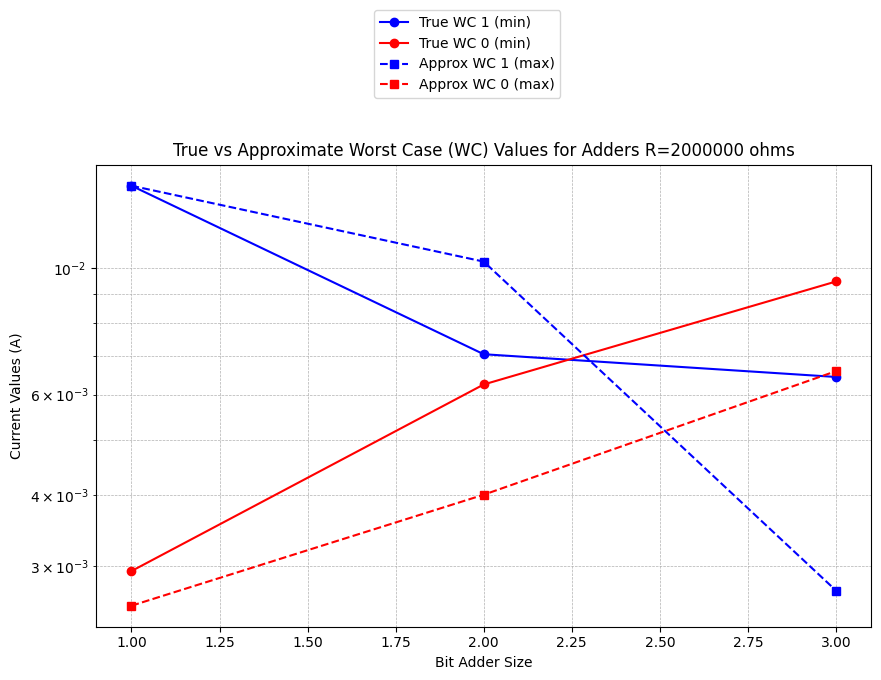

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data extraction from log text
bit_sizes = [i+1 for i in range(len(real_min_One))]

# True values
true_min_ones_currents = real_min_One
true_max_zeros_currents = real_max_Zero

# Approx values (same as true values in provided log)
approx_min_ones_currents = opt_min_One
approx_max_zeros_currents = opt_max_Zero

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(bit_sizes, true_min_ones_currents, 'bo-', label='True WC 1 (min)')
plt.plot(bit_sizes, true_max_zeros_currents, 'ro-', label='True WC 0 (min)')

plt.plot(bit_sizes, approx_min_ones_currents, 'bs--', label='Approx WC 1 (max)')
plt.plot(bit_sizes, approx_max_zeros_currents, 'rs--', label='Approx WC 0 (max)')

plt.xlabel('Bit Adder Size')
plt.ylabel('Current Values (A)')
plt.yscale('log')  # Log scale for better visualization
plt.title('True vs Approximate Worst Case (WC) Values for Adders R=2000000 ohms')
# Placing legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(0.35, 1.35))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.show()

In [365]:
approx_min_ones_currents

[np.float64(0.011199243011327012),
 np.float64(0.010832678742014821),
 np.float64(0.013642001458459643)]

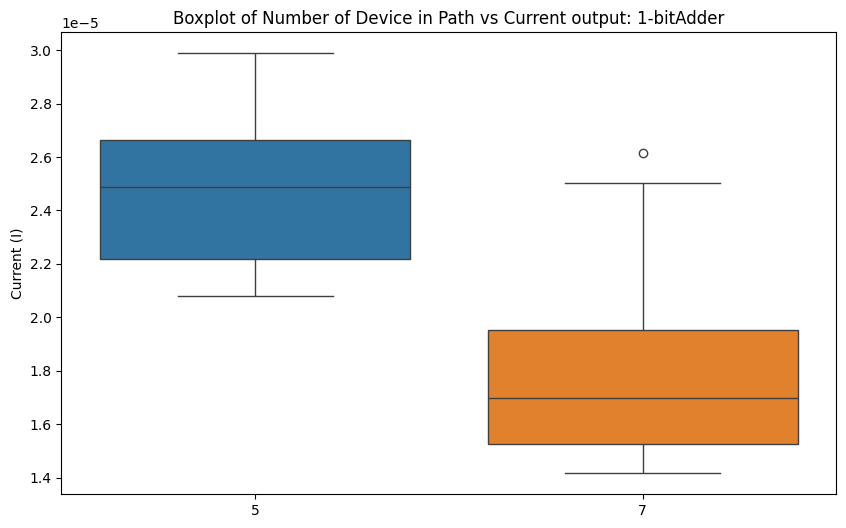

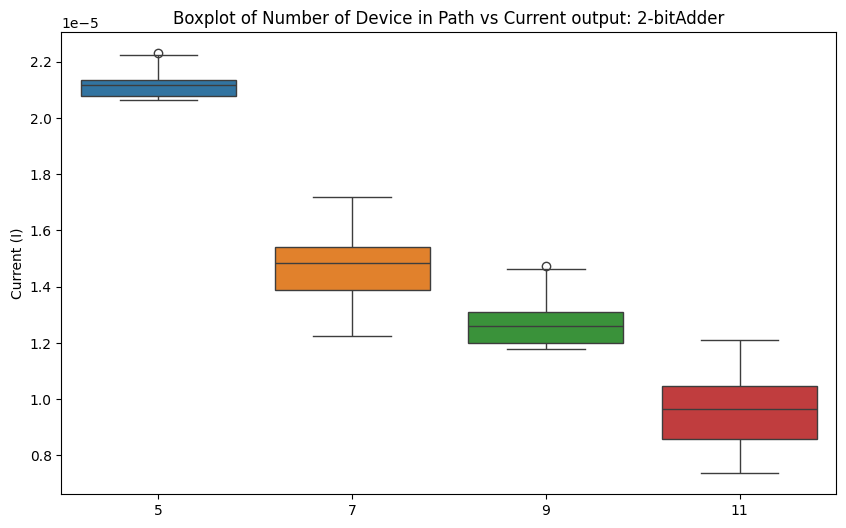

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplot_from_sorted_hashmap(data_map, adderBit, sort_keys=True):
    """
    Plots a boxplot (quartile graph) from a hashmap where:
    - Keys are labels for the boxplot.
    - Values are lists of values to be plotted.
    - Sorts the keys before plotting if sort_keys is True.
    """
    # Sort the dictionary by keys if required
    if sort_keys:
        data_map = dict(sorted(data_map.items()))

    # Extract sorted labels and corresponding data
    labels = list(data_map.keys())
    data = list(data_map.values())

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)
    
    # Set labels
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
    plt.ylabel("Current (I)")
    plt.title("Boxplot of Number of Device in Path vs Current output: "+adderBit)

    # Show the plot
    plt.show()

for adderBit in Adder_guardbandsVsReistancesDetailsMaps:
    plot_boxplot_from_sorted_hashmap(Adder_guardbandsVsReistancesDetailsMaps[adderBit]['AdderNumDevicesToCurrents_Map'], adderBit)

In [12]:
# Extract unique adders and device counts
adders = list(Adder_guardbandsVsReistancesDetailsMaps.keys())
devices = sorted({device for adder in adders for device in Adder_guardbandsVsReistancesDetailsMaps[adder]['AdderNumDevicesToAvgCurrent_Map'].keys()})

# Create a DataFrame to hold the current values
data = pd.DataFrame(index=adders, columns=devices, dtype=float)

# Create an annotation matrix for the heatmap text
annot_matrix = data.astype(str)

# Populate the DataFrame with current values and create annotation text
for adder in adders:
    for device in devices:
        if device in Adder_guardbandsVsReistancesDetailsMaps[adder]['AdderNumDevicesToAvgCurrent_Map']:
            current = Adder_guardbandsVsReistancesDetailsMaps[adder]['AdderNumDevicesToAvgCurrent_Map'][device]
            freqDevices = Adder_guardbandsVsReistancesDetailsMaps[adder]["AdderFrequencyOfNumDevices"][device]

            data.loc[adder, device] = current

            # Formatting annotation with scientific notation for current and frequency on the next line
            annot_matrix.loc[adder, device] = f"{current:.2e}\n({freqDevices})"
        else:
            annot_matrix.loc[adder, device] = ""


# Plotting the heatmap
plt.figure(figsize=(13, 7))
ax = sns.heatmap(data, annot=annot_matrix.values, fmt="", cmap="YlGnBu", cbar_kws={'label': 'Current (A)'},
                 linewidths=0.5, linecolor='gray', annot_kws={"fontsize": 10.5})  # Adjust font size here

# Set labels and title
plt.xlabel('Number of Devices')
plt.ylabel('Adder Type')
plt.title('Current Values for Different Adder Configurations and Device Counts')

# Show the plot
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1300x700 with 0 Axes>

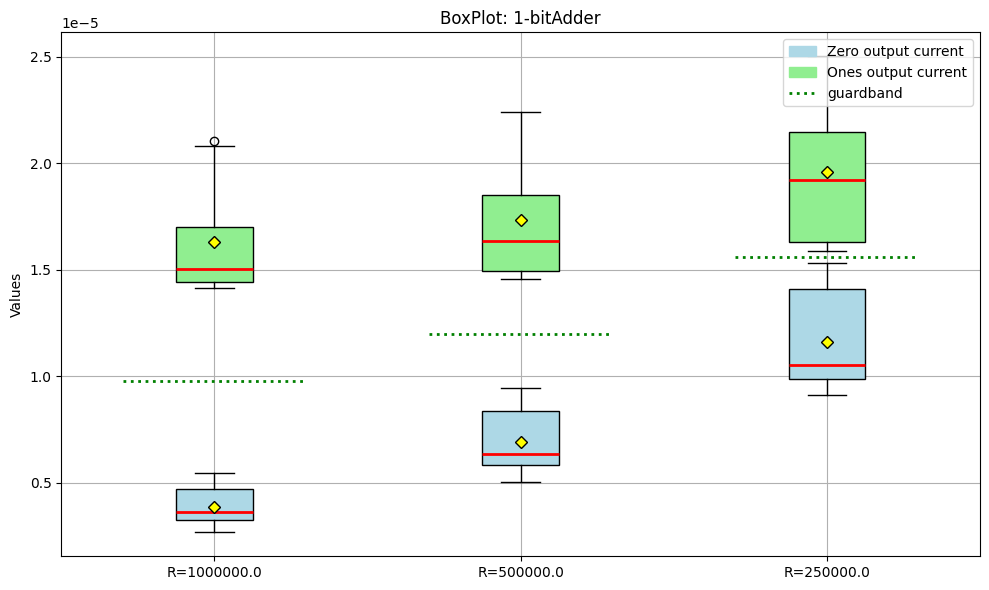

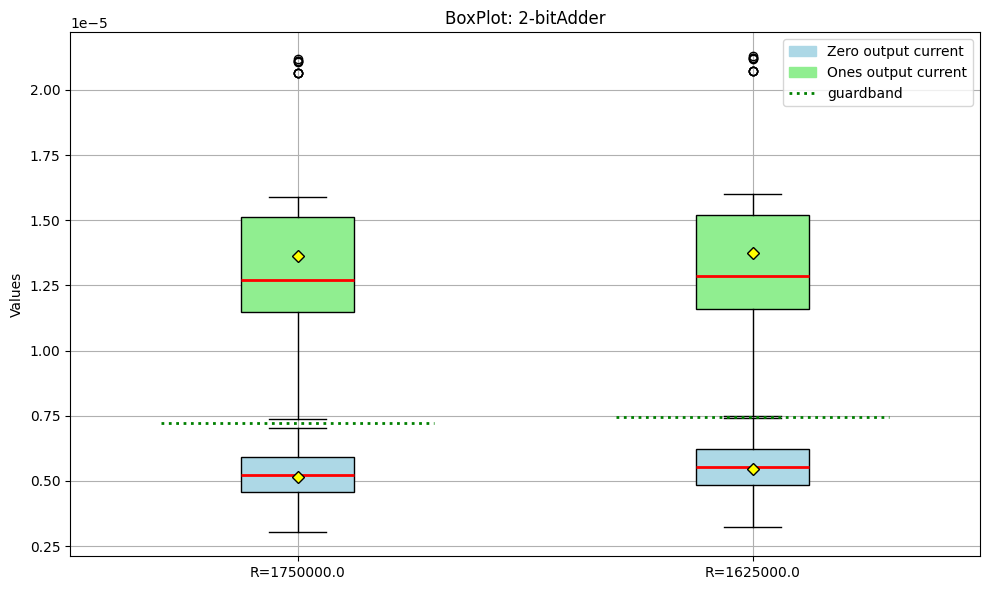

In [16]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


with open("Data/Adder_guardbandsVsReistancesDetailsMaps.pkl", "rb") as f:
    Adder_guardbandsVsReistancesDetailsMaps = pickle.load(f)

Adder_guardbandsVsReistancesDetailsMaps_keys = list(Adder_guardbandsVsReistancesDetailsMaps.keys())
for i in range(len(Adder_guardbandsVsReistancesDetailsMaps_keys)):
    key_adder = Adder_guardbandsVsReistancesDetailsMaps_keys[i]
    Adder_guardbandsVsReistancesDetailsMap = Adder_guardbandsVsReistancesDetailsMaps[key_adder]

    dataZeros = []
    dataOnes = []
    group_labels = []
    
    # Positions for each group
    pos = []
    guardband_values = []

    len_record_details = len(Adder_guardbandsVsReistancesDetailsMap["guardbands"])
    
    for j in range(len_record_details):
        dataZeros.append(Adder_guardbandsVsReistancesDetailsMap["zerosCurrents_lst"][j])
        dataOnes.append(Adder_guardbandsVsReistancesDetailsMap["onesCurrents_lst"][j])
        group_labels.append("R="+str(Adder_guardbandsVsReistancesDetailsMap["resistance_values"][j]))

        guardband_values.append(max(Adder_guardbandsVsReistancesDetailsMap["zerosCurrents_lst"][j])+(Adder_guardbandsVsReistancesDetailsMap["guardbands"][j]/2))
    
        pos.append(j+1)

    if(pos):

        plt.figure(figsize=(10, 6))
    
        
        # Plot dataZeros
        bp_zeros = plt.boxplot(
            dataZeros, 
            positions=pos, 
            patch_artist=True, 
            widths=0.25,             # Adjust width as desired
            showmeans=True,          
            boxprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2),
            meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='yellow')
        )
        
        # Color the boxes (dataZeros)
        for patch in bp_zeros['boxes']:
            patch.set_facecolor('lightblue')
        
        # Plot dataOnes
        bp_ones = plt.boxplot(
            dataOnes, 
            positions=pos, 
            patch_artist=True, 
            widths=0.25,
            showmeans=True,
            boxprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2),
            meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='yellow')
        )
    
        # Add green dotted lines based on each group's guardband value
        for j, guardband_value in enumerate(guardband_values):
            # We'll draw a short line around x_val (from x_val-0.3 to x_val+0.3):
            plt.hlines(
                y=guardband_value,
                xmin=pos[j]-0.3,
                xmax=pos[j]+0.3,
                colors='green',
                linestyles='dotted',
                linewidth=2
            )
        
        # Color the boxes (dataOnes)
        for patch in bp_ones['boxes']:
            patch.set_facecolor('lightgreen')
        
        # Move x-ticks to the midpoint between the two boxplots of each group
        plt.xticks(pos, group_labels)
        
        plt.ylabel("Values")
        plt.title("BoxPlot: "+key_adder)
        plt.grid(True)
        
        # Create legend elements
        zero_patch = mpatches.Patch(color='lightblue', label='Zero output current')
        one_patch = mpatches.Patch(color='lightgreen', label='Ones output current')
        guardband_line = mlines.Line2D([], [], color='green', linestyle='dotted', linewidth=2, label='guardband')
    
        plt.legend(handles=[zero_patch, one_patch, guardband_line], loc='upper right')
        
        plt.tight_layout()
        plt.show()

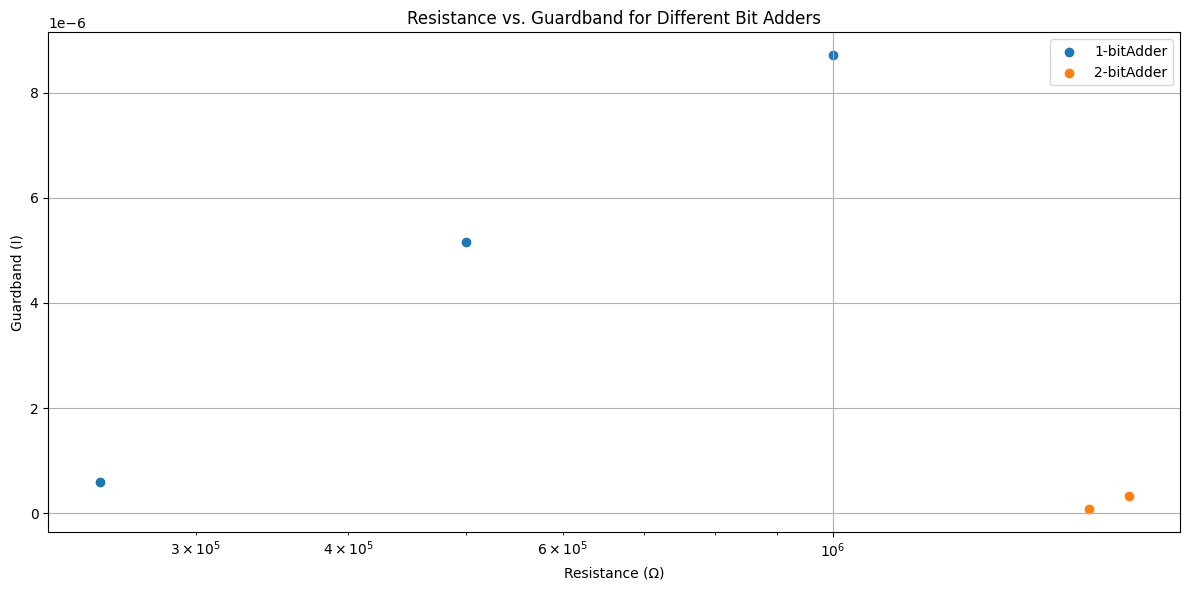

In [17]:
with open("Data/Adder_guardbandsVsReistancesDetailsMaps.pkl", "rb") as f:
    Adder_guardbandsVsReistancesDetailsMaps = pickle.load(f)

plt.figure(figsize=(12, 6))

# A color map or predefined list of colors can be used if you have multiple adders
# For example: colors = plt.cm.tab10(np.linspace(0, 1, len(Adder_guardbandsVsReistancesDetailsMaps)))
# But often letting matplotlib handle defaults is fine.

for i, (adder_name, data) in enumerate(Adder_guardbandsVsReistancesDetailsMaps.items()):
    guardbands = data['guardbands']
    resistances = data['resistance_values']

    
    # Plot them (resistance on x-axis, guardband on y-axis)
    # marker='o' to see points, linestyle='-' to connect them
    plt.scatter(
        resistances, guardbands, 
        marker='o', 
        label=adder_name
    )

plt.xscale('log')  # Often helpful if resistance spans large orders of magnitude
plt.xlabel('Resistance (Ω)')
plt.ylabel('Guardband (I)')
plt.title('Resistance vs. Guardband for Different Bit Adders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [735]:
# Suppose you have the following lists (all of the same length)
AdderBit = ["1-Bit Adder", "2-Bit Adder", "3-Bit Adder", "4-Bit Adder", "5-Bit Adder"]
SBDDSize = ['13 x 9', '26 x 18', '39 x 27', '52 x 36', '131 x 76']
CrossbarSize = [16, 32, 64, 64, 256]
NumberOfBooleanPermutations = [2, 4, 6, 8, 10]
NumberOfBooleanIterations = [2**2, 2**4, 2**6, 2**8, 2**10]
TimeForEachIterations = [1.5, 8.5, 50, 110, 410]
TotalTimeForEachIterations = [NumberOfBooleanIterations[i]*TimeForEachIterations[i] for i in range(len(NumberOfBooleanIterations))]
TotalTimeInHours = [TotalTimeForEachIterations[i]/3600 for i in range(len(TotalTimeForEachIterations))]
# Put them into a dictionary where each key is the column name,
# and each value is one of the lists:
data = {
    "AdderBit": AdderBit,
    "SBDDSize (V x E)": SBDDSize,
    "CrossbarSize >max(V, E)": CrossbarSize,
    "Number of boolean inputs (n)":NumberOfBooleanPermutations,
    "Total Input permuatations (2^n)":NumberOfBooleanIterations,
    "Time for each boolean input (t)":TimeForEachIterations,
    "Total Time For all boolean inputs ....... T = (t x 2^n)": TotalTimeForEachIterations,
    "Total Time In Hours For Single Binary search iterations of resitance Thr = (T/3600) hours": TotalTimeInHours,
    "Total Iterations (ThrX10) time": [i*10 for i in TotalTimeInHours]
}

# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame(data)

df

,AdderBit,SBDDSize (V x E),"CrossbarSize >max(V, E)",Number of boolean inputs (n),Total Input permuatations (2^n),Time for each boolean input (t),Total Time For all boolean inputs ....... T = (t x 2^n),Total Time In Hours For Single Binary search iterations of resitance Thr = (T/3600) hours,Total Iterations (ThrX10) time
0,1-Bit Adder,13 x 9,16,2,4,1.5,6.0,0.001667,0.016667
1,2-Bit Adder,26 x 18,32,4,16,8.5,136.0,0.037778,0.377778
2,3-Bit Adder,39 x 27,64,6,64,50.0,3200.0,0.888889,8.888889
3,4-Bit Adder,52 x 36,64,8,256,110.0,28160.0,7.822222,78.222222
4,5-Bit Adder,131 x 76,256,10,1024,410.0,419840.0,116.622222,1166.222222


In [64]:
import numpy as np
import time
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def check_matrix_sparsity_and_efficiency(A, b=None, sparsity_threshold=0.3):
    """
    Checks if a given 2D NumPy matrix A is sparse, based on the ratio of non-zeros.
    If b is given, also compare the runtime of dense vs. sparse solvers.

    Parameters
    ----------
    A : np.matrix or np.ndarray
        The matrix of interest.
    b : np.ndarray or list or None, optional
        The RHS vector for testing linear solving.
        If None, no solver timing is performed.
    sparsity_threshold : float
        If non_zero_ratio < sparsity_threshold, we classify the matrix as "sparse".

    Returns
    -------
    None
    """

    # Ensure A is a NumPy array
    A_arr = np.array(A, dtype=float)  # convert np.matrix to np.ndarray if needed

    print("Matrix dimentions (m x m):", A_arr.shape)
    
    # 1) Check the sparsity ratio
    total_elements = A_arr.size
    nonzero_elements = np.count_nonzero(A_arr)
    nonzero_ratio = nonzero_elements / total_elements
    zero_ratio = 1.0 - nonzero_ratio

    print("=== Sparsity Check ===")
    print(f"Matrix shape: {A_arr.shape}")
    print(f"Total elements: {total_elements}")
    print(f"Non-zero elements: {nonzero_elements}")
    print(f"Non-zero ratio: {nonzero_ratio:.2f}  ({nonzero_ratio*100:.2f} %)")
    print(f"Zero ratio: {zero_ratio:.2f}        ({zero_ratio*100:.2f} %)")

    if nonzero_ratio < sparsity_threshold:
        print("Matrix is considered SPARSE based on the given threshold.")
    else:
        print("Matrix is NOT considered sparse based on the given threshold.")

    # 2) (Optional) Compare efficiency of dense vs. sparse solver
    if b is not None:
        print("\n=== Solver Efficiency Check ===")
        
        # Ensure b is a 1D array
        b_arr = np.array(b, dtype=float).ravel()

        # Dense solve timing
        start_time = time.time()
        x_dense = np.linalg.solve(A_arr, b_arr)
        dense_time = time.time() - start_time

        # Sparse solve timing
        A_csr = sp.csr_matrix(A_arr)
        start_time = time.time()
        x_sparse = spla.spsolve(A_csr, b_arr)
        sparse_time = time.time() - start_time

        print(f"Dense solve time  : {dense_time:.6f} seconds")
        print(f"Sparse solve time : {sparse_time:.6f} seconds")

        # (Optional) Compare solutions
        diff = np.linalg.norm(x_dense - x_sparse, ord=2)
        print(f"Difference between dense and sparse solutions: {diff:.2e}")

    print("\nDone.\n")


# ======================
# Example usage:
# ======================
if __name__ == "__main__":
    # Example 1: A small "sparse" matrix
    A_example_1 = AnalogPathTest.tempMatrix[0]
    b_example_1 = AnalogPathTest.tempMatrix[1]

    check_matrix_sparsity_and_efficiency(A_example_1, b_example_1, sparsity_threshold=0.2)

Matrix dimentions (m x m): (128, 128)
=== Sparsity Check ===
Matrix shape: (128, 128)
Total elements: 16384
Non-zero elements: 8256
Non-zero ratio: 0.50  (50.39 %)
Zero ratio: 0.50        (49.61 %)
Matrix is NOT considered sparse based on the given threshold.

=== Solver Efficiency Check ===
Dense solve time  : 0.000000 seconds
Sparse solve time : 0.001999 seconds
Difference between dense and sparse solutions: 8.72e-15

Done.



In [333]:
def extend_path_by_two(orig_path):
    
    new_path = []
    new_path.extend(orig_path[:-2])

    subpath = []
    final_node = orig_path[-1]
    
    prev1, prev2 = new_path[-1], new_path[-2]
    if(prev1[0]==prev2[0]):
        if((7,4) not in orig_path):
            subpath.append((7, prev1[1]))
            subpath.append((7, 4))
            subpath.append((final_node[0], 4))
    elif(prev1[1]==prev2[1]):
        print("dont know")
        return
    
    new_path.extend(subpath)
    new_path.append(final_node)
    
    return new_path

# ---------------------------
# Example usage:
original_path = [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (8, 3), (8, 12)]
# [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (7, 3), (7, 4), (8, 4), (8, 12)]
extended = extend_path_by_two(original_path)
print("Original:", original_path)
print("Extended:", extended)

Original: [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (8, 3), (8, 12)]
Extended: [(0, 10), (3, 10), (3, 7), (6, 7), (6, 3), (7, 3), (7, 4), (8, 4), (8, 12)]
